Updated code (Resolves the consolidation issue)

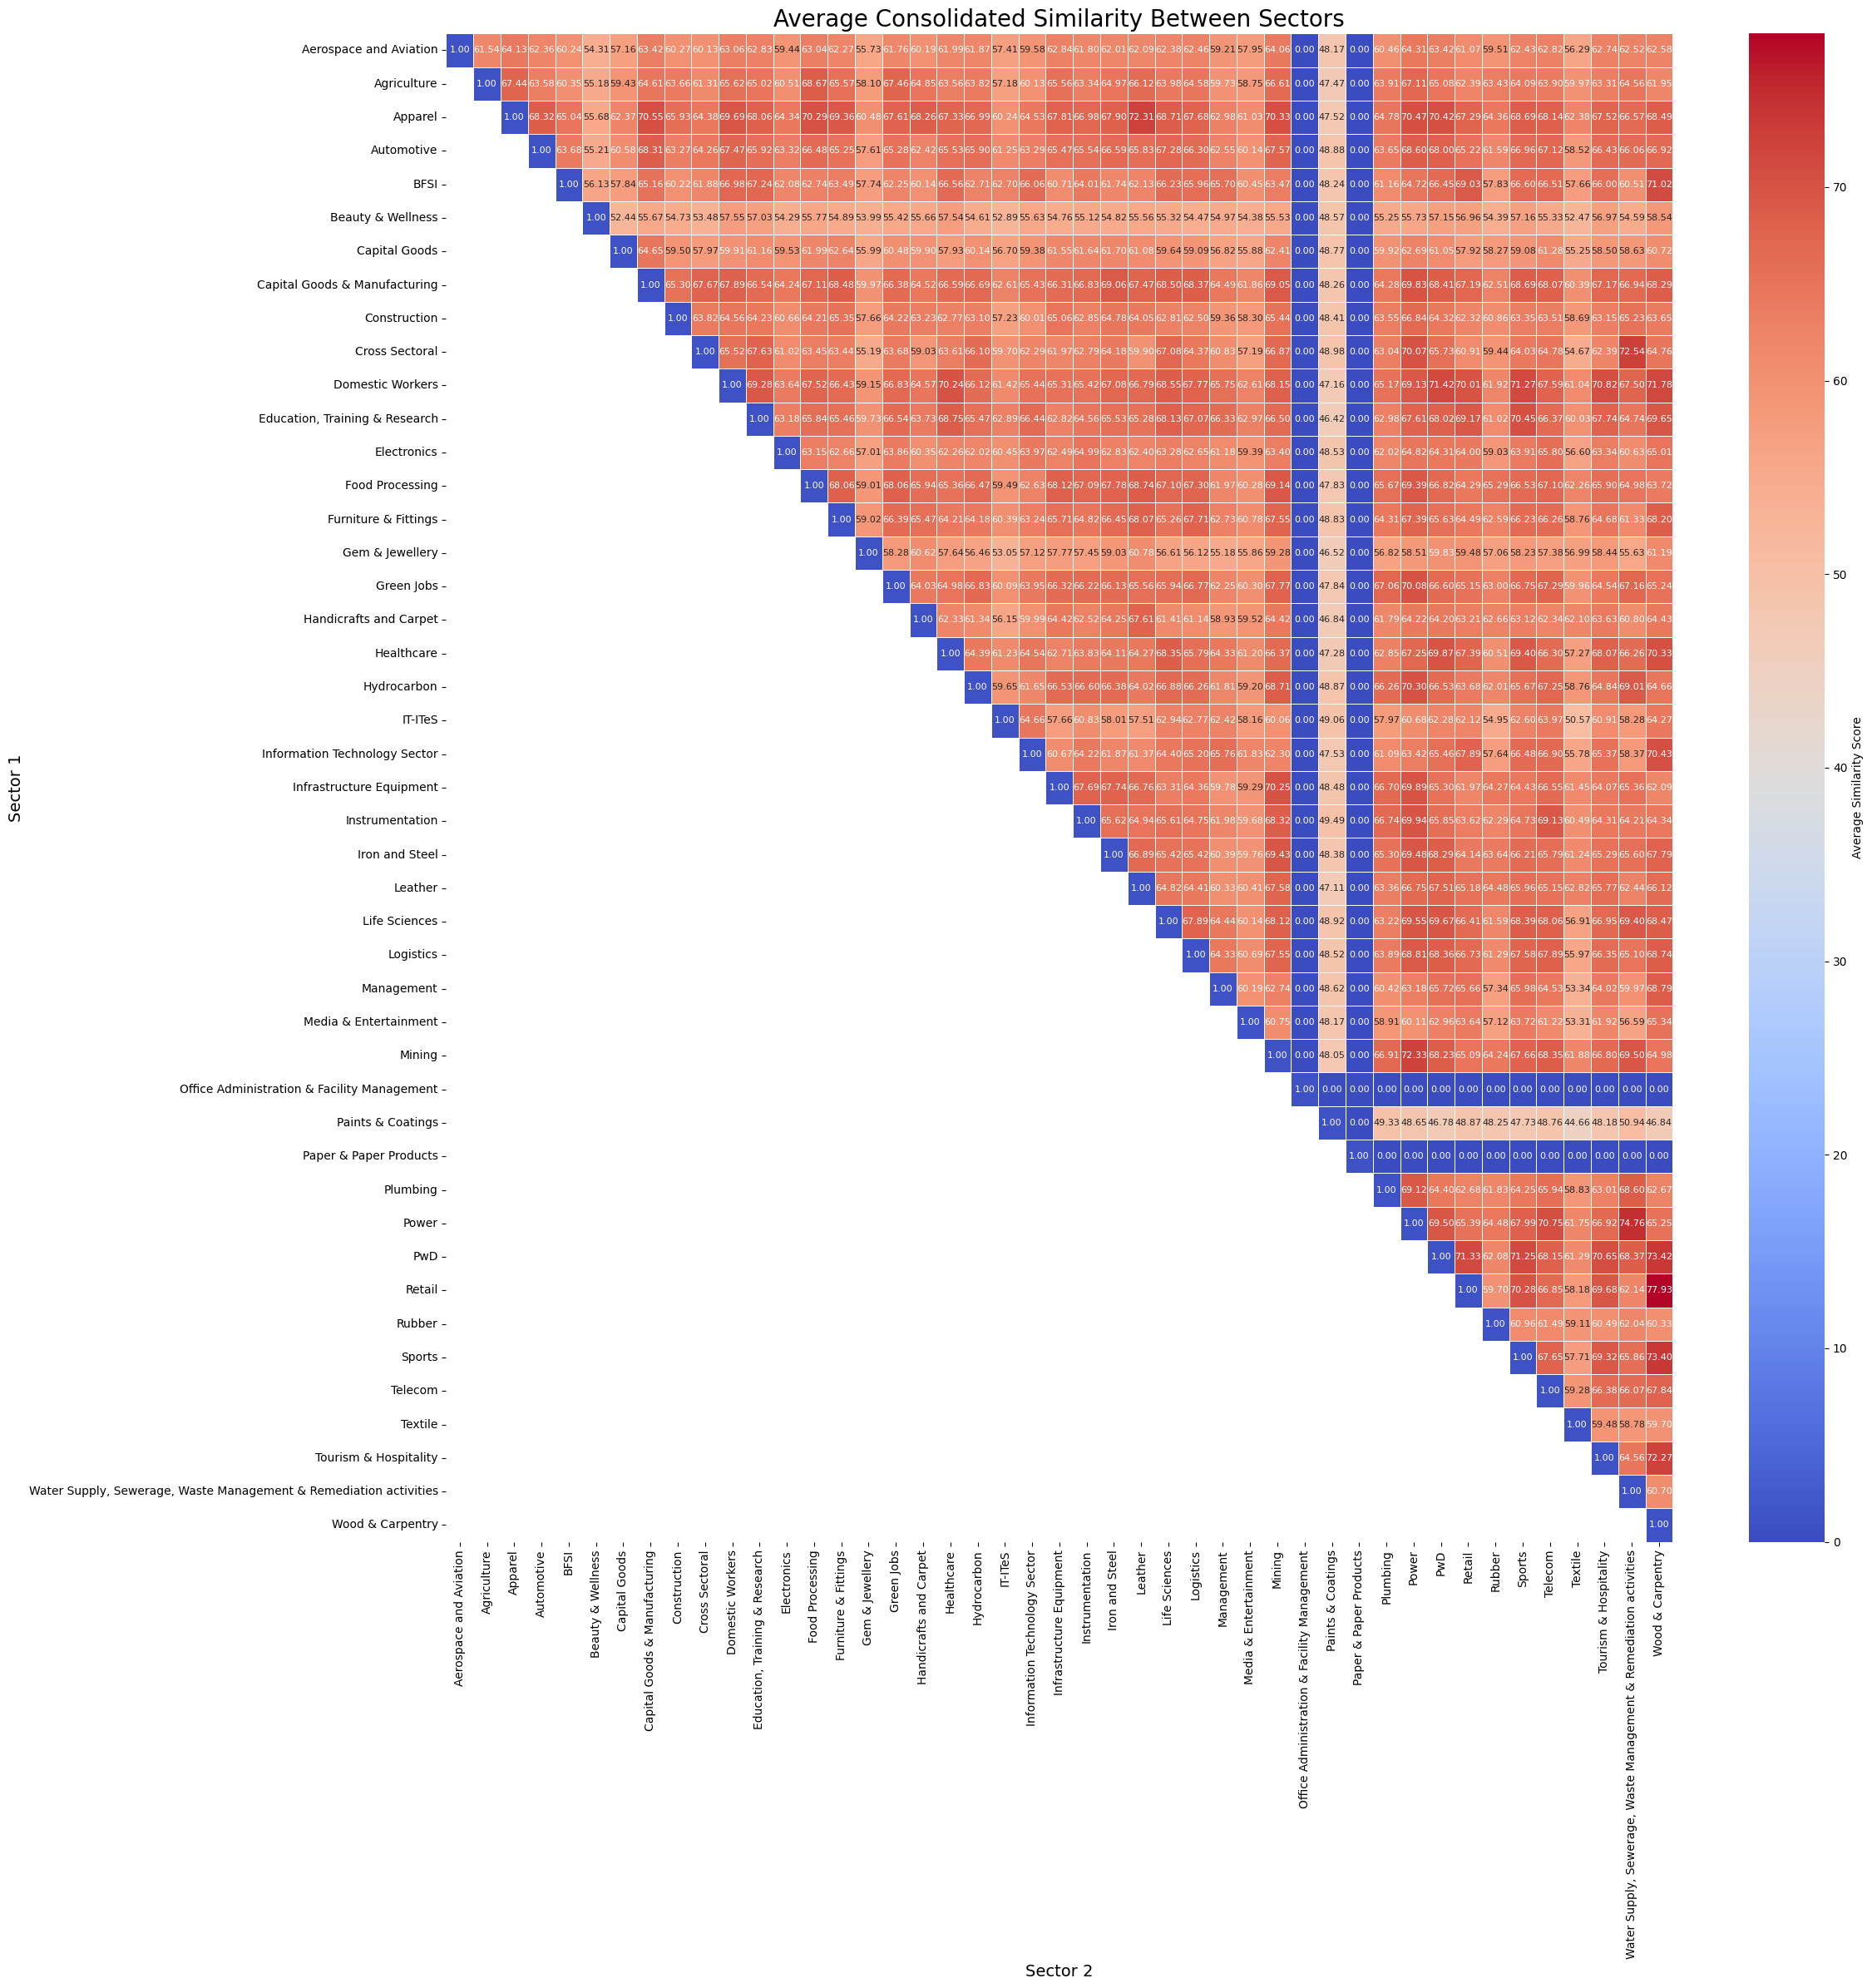

Heatmap generated: sector_similarity_heatmap_final.png
Consolidated table generated: sector_similarity_table_final.csv


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Set a large display limit for Pandas DataFrames for diagnostics
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- CONFIGURATION ---
PARQUET_FILE = 'all_similarities.paraquet'
CSV_FILE = 'qp-listings.csv'
OUTPUT_HEATMAP = 'sector_similarity_heatmap_final.png'
OUTPUT_TABLE = 'sector_similarity_table_final.csv'

# --- DATA LOADING AND CLEANING ---

# 1. Load the datasets, handling potential filename variations
try:
    df_sim = pd.read_parquet(PARQUET_FILE)
except FileNotFoundError:
    df_sim = pd.read_parquet('all_similarities.parquet')

df_listings = pd.read_csv(CSV_FILE)

# 2. Standardize a specific sector name to ensure consistent grouping
target_name = "Oï¬ƒce Administration & Facility Management"
new_name = "Administration & Facility Management"
df_listings['Sector Name'] = df_listings['Sector Name'].replace(target_name, new_name)

# 3. Calculate the combined average similarity score
# --- UPDATED CALCULATION LOGIC ---
# The 'embedding_similarity' is first multiplied by 100, and then averaged with the other two scores.

scaled_embedding = df_sim['embedding_similarity'] * 100

# Calculate the average of the three scores using the scaled embedding value
df_sim['average_similarity'] = (scaled_embedding + df_sim['task_similarity'] + df_sim['nsqf_level_similarity']) / 3

# --- END UPDATED CALCULATION LOGIC ---

# --- QP CODE TO SECTOR MAPPING (The Waterfall Logic) ---

# Function to generate the versioned code key (e.g., TSC_Q2301_4.0)
def generate_versioned_key(row):
    """Creates the 'qpCode_version.0' format for advanced matching."""
    code = str(row['qpCode'])
    version = str(row['qp_version'])
    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"

# Create all three potential matching keys in the listing data
df_listings['match_key_1'] = df_listings['qpCode']
df_listings['match_key_2'] = df_listings.apply(generate_versioned_key, axis=1)
df_listings['match_key_3'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)

# Build the comprehensive master mapping dictionary
map_1 = df_listings[['match_key_1', 'Sector Name']].rename(columns={'match_key_1': 'join_key'})
map_2 = df_listings[['match_key_2', 'Sector Name']].rename(columns={'match_key_2': 'join_key'})
map_3 = df_listings[['match_key_3', 'Sector Name']].rename(columns={'match_key_3': 'join_key'})

master_map = pd.concat([map_1, map_2, map_3])
master_map = master_map.dropna(subset=['join_key'])
master_map = master_map[master_map['join_key'] != 'nan']
master_map = master_map.drop_duplicates(subset=['join_key'])

# --- MERGING AND CONSOLIDATION ---

# Merge to get the raw Sector names for both QP codes
df_merged = df_sim.merge(master_map, left_on='qp1_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'RawSector1'}).drop(columns=['join_key'])

df_merged = df_merged.merge(master_map, left_on='qp2_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'RawSector2'}).drop(columns=['join_key'])

# Filter out rows where sector mapping failed
df_clean = df_merged.dropna(subset=['RawSector1', 'RawSector2']).copy()

def consolidate_sectors(row):
    """Sorts the two sector names alphabetically to create a canonical pair key.
    This ensures that (A, B) and (B, A) are treated as the same pair for aggregation."""
    s1 = row['RawSector1']
    s2 = row['RawSector2']
    # Use tuple sorting for reliable comparison
    return pd.Series(sorted((s1, s2)), index=['Sector1', 'Sector2'])

# Apply the consolidation logic
df_clean[['Sector1', 'Sector2']] = df_clean.apply(consolidate_sectors, axis=1)

# --- MATRIX CREATION AND SYMMETRIZATION ---

# 1. Calculate the Consolidated Average
# All (A, B) and (B, A) interactions are now averaged together
heatmap_data = df_clean.groupby(['Sector1', 'Sector2'])['average_similarity'].mean().reset_index()

# 2. Pivot the data to a matrix form
heatmap_matrix = heatmap_data.pivot(index='Sector1', columns='Sector2', values='average_similarity')

# 3. Get the complete list of 45 sectors for consistent axis ordering
all_sectors = sorted(df_listings['Sector Name'].dropna().unique())

# 4. Reindex to ensure a 45x45 matrix size, filling missing pairs (which did not interact) with NaN
heatmap_matrix = heatmap_matrix.reindex(index=all_sectors, columns=all_sectors)

# 5. Mirror the data to make the matrix symmetric for display
# This ensures that Similarity(A, B) = Similarity(B, A)
# The T property (transpose) flips the matrix, and we use fillna to combine it with the original.
# We fill NaN (bottom triangle) with the values from the transposed upper triangle.
symmetric_matrix = heatmap_matrix.fillna(0) + heatmap_matrix.T.fillna(0)

# Final Symmetrization: Fill the lower triangle with the upper triangle values
final_matrix = symmetric_matrix.mask(symmetric_matrix == 0, heatmap_matrix)
final_matrix = final_matrix.fillna(0)

# 6. Apply self-similarity = 1.0 assumption for the diagonal if not provided by data
# This ensures that a sector compared to itself is marked as 1.0 (or the maximum expected similarity)
np.fill_diagonal(final_matrix.values, np.diag(final_matrix.values) + (1.0 - np.diag(final_matrix.values)))

# --- HEATMAP GENERATION ---

plt.figure(figsize=(24, 24))

# Create mask for the LOWER triangle (k=-1 keeps the diagonal visible, masking everything below it)
# This results in the desired Top-Right triangular display
mask = np.tril(np.ones_like(final_matrix, dtype=bool), k=-1)

sns.heatmap(final_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=.5, cbar_kws={'label': 'Average Similarity Score'},
            annot_kws={"size": 8})

plt.title('Average Consolidated Similarity Between Sectors', fontsize=20)
plt.xlabel('Sector 2', fontsize=14)
plt.ylabel('Sector 1', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

plt.savefig(OUTPUT_HEATMAP)
plt.show()

# --- SAVE TABLE (Unconsolidated format for easy review) ---

# The heatmap_data already contains the consolidated pairs (A, B where A <= B)
# We use this as the primary table output
similarity_table = heatmap_data.sort_values(by='average_similarity', ascending=False)
similarity_table.to_csv(OUTPUT_TABLE, index=False)

print(f"Heatmap generated: {OUTPUT_HEATMAP}")
print(f"Consolidated table generated: {OUTPUT_TABLE}")

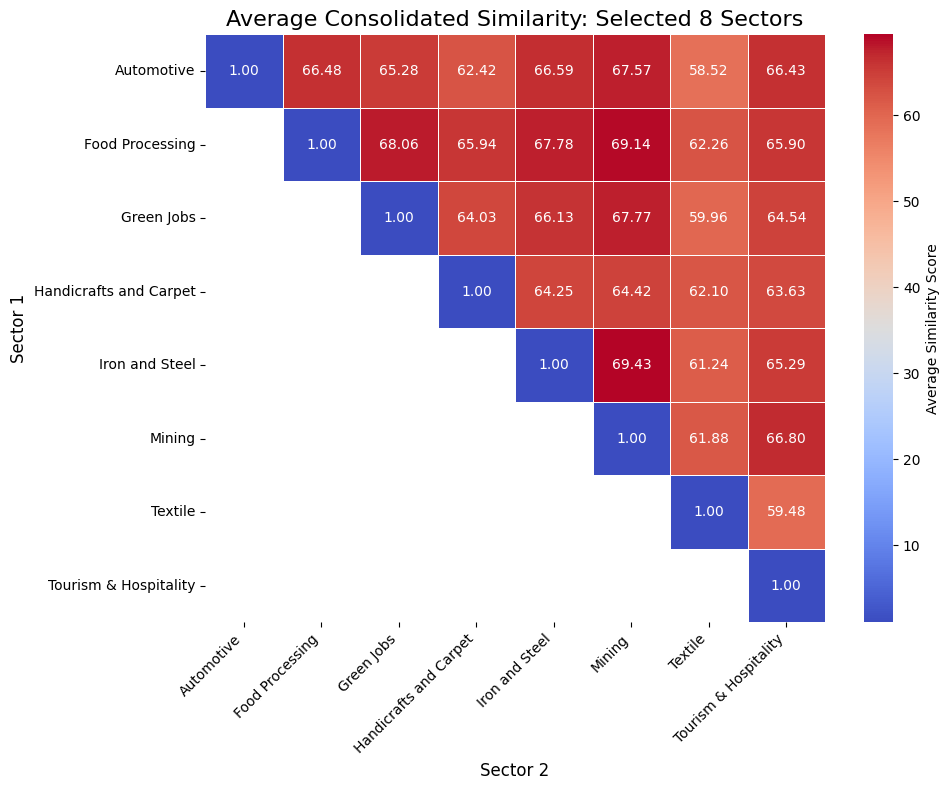

Heatmap generated: sector_similarity_heatmap_8_sectors.png
Consolidated table generated: sector_similarity_table_8_sectors.csv


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
OUTPUT_HEATMAP = 'sector_similarity_heatmap_8_sectors.png'
OUTPUT_TABLE = 'sector_similarity_table_8_sectors.csv'

# 1. Load the datasets
try:
    df_sim = pd.read_parquet('all_similarities.paraquet')
except FileNotFoundError:
    df_sim = pd.read_parquet('all_similarities.parquet')

df_listings = pd.read_csv('qp-listings.csv')

# 2. Define the Target Sectors (The 8 specific ones)
target_sectors = [
    "Automotive",
    "Food Processing",
    "Green Jobs",
    "Handicrafts and Carpet",
    "Iron and Steel",
    "Mining",
    "Textile",
    "Tourism & Hospitality"
]
# Ensure the list is sorted alphabetically for consistent plotting
target_sectors = sorted(target_sectors)

# 3. Pre-processing & Data Cleaning

# The 'embedding_similarity' is first multiplied by 100, and then averaged with the other two scores.
scaled_embedding = df_sim['embedding_similarity'] * 100
df_sim['average_similarity'] = (scaled_embedding + df_sim['task_similarity'] + df_sim['nsqf_level_similarity']) / 3
# --- END UPDATED CALCULATION LOGIC ---


# Fix Sector Name in CSV (Standard procedure)
target_name = "Oï¬ƒce Administration & Facility Management"
new_name = "Administration & Facility Management"
df_listings['Sector Name'] = df_listings['Sector Name'].replace(target_name, new_name)

# 4. Build the Master Lookup (Waterfall Matching Logic)
# Match Key 1: Original Code
df_listings['match_key_1'] = df_listings['qpCode']

# Match Key 2: Versioned Code (e.g., Code_4.0)
def format_version_key(row):
    """Creates the 'qpCode_version.0' format for advanced matching."""
    code = str(row['qpCode'])
    version = str(row['qp_version'])
    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"
df_listings['match_key_2'] = df_listings.apply(format_version_key, axis=1)

# Match Key 3: Filename (minus .json)
df_listings['match_key_3'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)

# Stack mappings
map_1 = df_listings[['match_key_1', 'Sector Name']].rename(columns={'match_key_1': 'join_key'})
map_2 = df_listings[['match_key_2', 'Sector Name']].rename(columns={'match_key_2': 'join_key'})
map_3 = df_listings[['match_key_3', 'Sector Name']].rename(columns={'match_key_3': 'join_key'})

master_map = pd.concat([map_1, map_2, map_3])
master_map = master_map.dropna(subset=['join_key'])
master_map = master_map[master_map['join_key'] != 'nan']
master_map = master_map.drop_duplicates(subset=['join_key'])

# 5. Merge Data
# Merge to get the raw Sector names for both QP codes
df_merged = df_sim.merge(master_map, left_on='qp1_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'RawSector1'}).drop(columns=['join_key'])

df_merged = df_merged.merge(master_map, left_on='qp2_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'RawSector2'}).drop(columns=['join_key'])

# Filter out rows where sector mapping failed
df_clean = df_merged.dropna(subset=['RawSector1', 'RawSector2']).copy()

# 6. Consolidation Logic
def consolidate_sectors(row):
    """Sorts the two sector names alphabetically to create a canonical pair key.
    This ensures that (A, B) and (B, A) are treated as the same pair for aggregation."""
    s1 = row['RawSector1']
    s2 = row['RawSector2']
    # Use tuple sorting for reliable comparison
    return pd.Series(sorted((s1, s2)), index=['Sector1', 'Sector2'])

# Apply the consolidation and filter for only the 8 target sectors
df_clean[['Sector1', 'Sector2']] = df_clean.apply(consolidate_sectors, axis=1)

# Filter for ONLY the 8 Target Sectors in the consolidated columns
df_subset = df_clean[
    (df_clean['Sector1'].isin(target_sectors)) &
    (df_clean['Sector2'].isin(target_sectors))
]

# 7. Create Matrix (Symmetrized)

# 1. Calculate the Consolidated Average
heatmap_data = df_subset.groupby(['Sector1', 'Sector2'])['average_similarity'].mean().reset_index()

# 2. Pivot the data to a matrix form
# This creates a matrix where data only exists for A <= B
heatmap_matrix = heatmap_data.pivot(index='Sector1', columns='Sector2', values='average_similarity')

# 3. Reindex to force the 8x8 matrix size
heatmap_matrix = heatmap_matrix.reindex(index=target_sectors, columns=target_sectors)

# 4. Final Symmetrization for Display: Fill NaNs in the lower triangle with 0
final_matrix = heatmap_matrix.fillna(0)

# 5. Apply self-similarity = 1.0 assumption for the diagonal
np.fill_diagonal(final_matrix.values, np.diag(final_matrix.values) + (1.0 - np.diag(final_matrix.values)))

# 8. Generate Heatmap
plt.figure(figsize=(10, 8)) # Appropriate size for 8x8

# Mask the LOWER triangle (Top-Right visible)
mask = np.tril(np.ones_like(final_matrix, dtype=bool), k=-1)

sns.heatmap(final_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=.5, cbar_kws={'label': 'Average Similarity Score'})

plt.title('Average Consolidated Similarity: Selected 8 Sectors', fontsize=16)
plt.xlabel('Sector 2', fontsize=12)
plt.ylabel('Sector 1', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(OUTPUT_HEATMAP)
plt.show()

# 9. Save Table
# The heatmap_data already contains the consolidated pairs (A, B where A <= B)
similarity_table = heatmap_data.sort_values(by='average_similarity', ascending=False)
similarity_table.to_csv(OUTPUT_TABLE, index=False)

print(f"Heatmap generated: {OUTPUT_HEATMAP}")
print(f"Consolidated table generated: {OUTPUT_TABLE}")

Generating Graph for similarity values visualisation

Data loaded successfully.


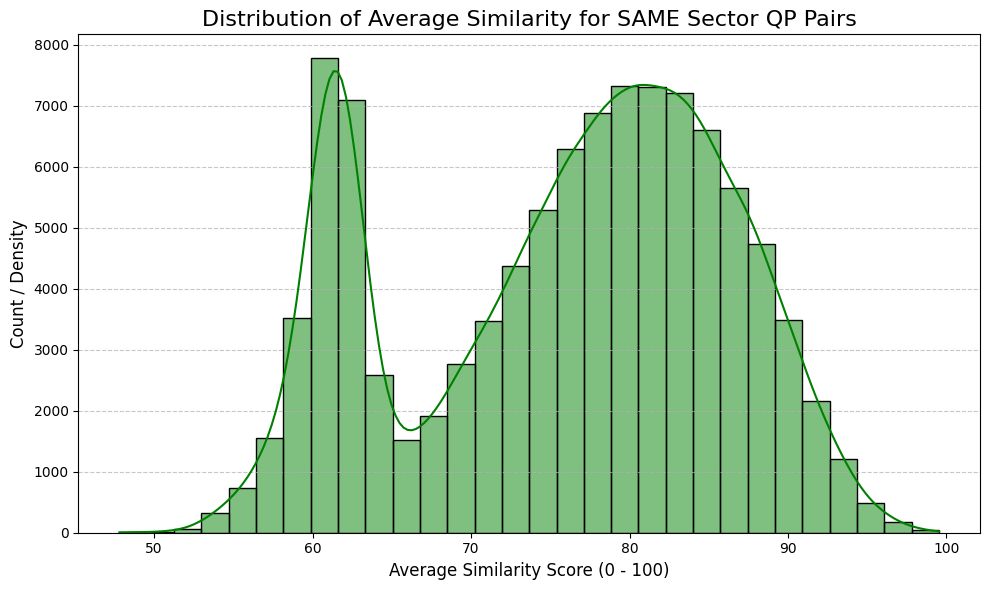

Plot generated: similarity_distribution_same_sector.png
Total Same Sector Pairs: 102601


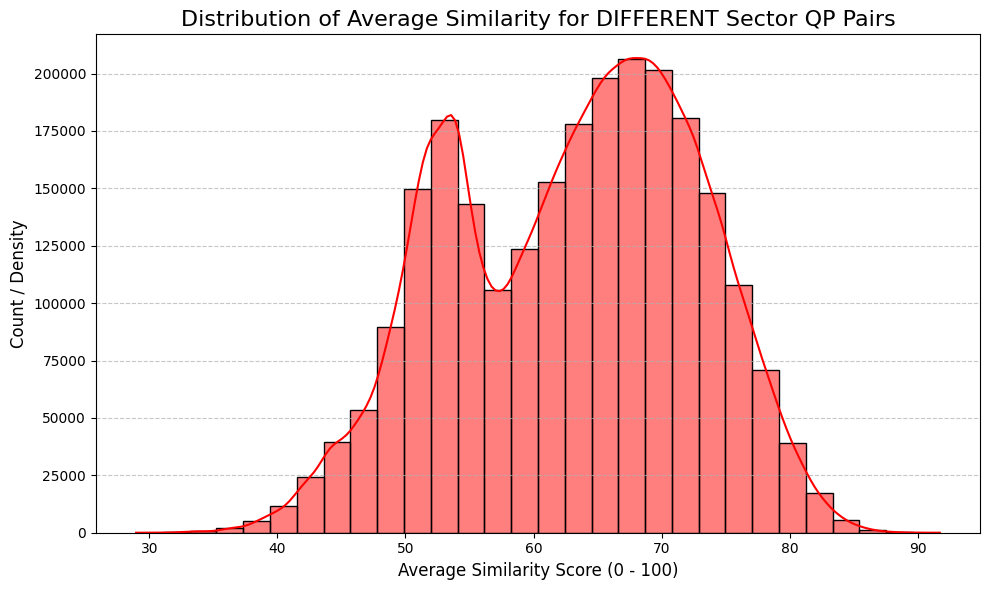

Plot generated: similarity_distribution_different_sector.png
Total Different Sector Pairs: 2436530


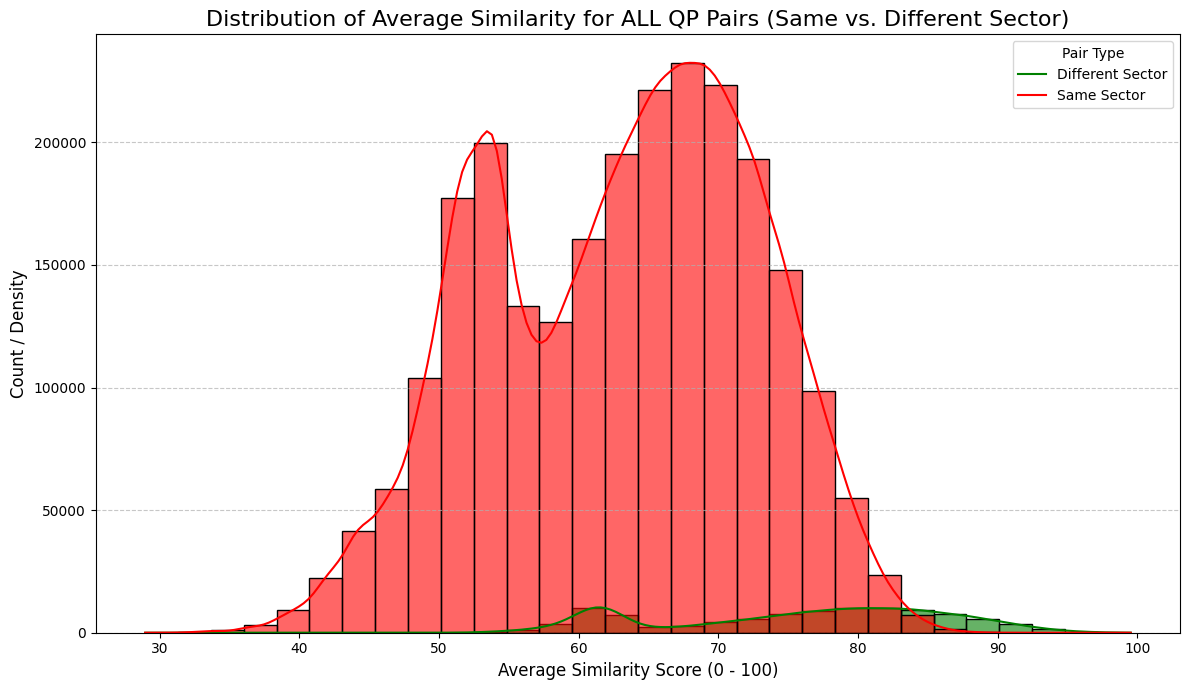

Plot generated: similarity_distribution_all_pairs.png
Total Cleaned Pairs: 2539131


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Set a large display limit for Pandas DataFrames for diagnostics
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- CONFIGURATION ---
# *** NOTE: Corrected the filename based on your request ***
PARQUET_FILE = 'updated_all_similarities.paraquet'
CSV_FILE = 'qp-listings.csv'
OUTPUT_PLOT_SAME = 'similarity_distribution_same_sector.png'
OUTPUT_PLOT_DIFFERENT = 'similarity_distribution_different_sector.png'
OUTPUT_PLOT_ALL = 'similarity_distribution_all_pairs.png'


# --- DATA LOADING AND CLEANING ---

# 1. Load the datasets, handling potential filename variations
try:
    df_sim = pd.read_parquet(PARQUET_FILE)
except FileNotFoundError:
    # Try common misspellings just in case
    df_sim = pd.read_parquet('updated_all_similarities.parquet')
    print(f"Loaded {PARQUET_FILE} with corrected extension.")

df_listings = pd.read_csv(CSV_FILE)
print("Data loaded successfully.")

# 2. Standardize a specific sector name to ensure consistent grouping
target_name = "Oï¬ƒce Administration & Facility Management"
new_name = "Administration & Facility Management"
df_listings['Sector Name'] = df_listings['Sector Name'].replace(target_name, new_name)

# 3. Calculate the combined average similarity score
# Embedding is scaled by 100, then averaged with the other two scores.
scaled_embedding = df_sim['embedding_similarity'] * 100
df_sim['average_similarity'] = (scaled_embedding + df_sim['task_similarity'] + df_sim['nsqf_level_similarity']) / 3


# --- QP CODE TO SECTOR MAPPING (The Waterfall Logic) ---

def generate_versioned_key(row):
    """Creates the 'qpCode_version.0' format for advanced matching."""
    code = str(row['qpCode'])
    version = str(row['qp_version'])
    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"

# Create all three potential matching keys in the listing data
df_listings['match_key_1'] = df_listings['qpCode']
df_listings['match_key_2'] = df_listings.apply(generate_versioned_key, axis=1)
df_listings['match_key_3'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)

# Build the comprehensive master mapping dictionary
map_1 = df_listings[['match_key_1', 'Sector Name']].rename(columns={'match_key_1': 'join_key'})
map_2 = df_listings[['match_key_2', 'Sector Name']].rename(columns={'match_key_2': 'join_key'})
map_3 = df_listings[['match_key_3', 'Sector Name']].rename(columns={'match_key_3': 'join_key'})

master_map = pd.concat([map_1, map_2, map_3])
master_map = master_map.dropna(subset=['join_key'])
master_map = master_map[master_map['join_key'] != 'nan']
# Use only the first mapping for a key if multiple exist
master_map = master_map.drop_duplicates(subset=['join_key'], keep='first')


# --- MERGING AND SECTOR CLASSIFICATION ---

# Merge to get the raw Sector names for both QP codes
df_merged = df_sim.merge(master_map, left_on='qp1_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'Sector1'}).drop(columns=['join_key'])

df_merged = df_merged.merge(master_map, left_on='qp2_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'Sector2'}).drop(columns=['join_key'])

# Filter out rows where sector mapping failed
df_clean = df_merged.dropna(subset=['Sector1', 'Sector2']).copy()

# 🔑 NEW STEP: Create the classification column
df_clean['is_same_sector'] = np.where(df_clean['Sector1'] == df_clean['Sector2'], 1, 0)
df_clean['sector_group'] = np.where(df_clean['is_same_sector'] == 1, 'Same Sector', 'Different Sector')

# --- PLOTTING ---

# Define a consistent plotting function
def plot_similarity_distribution(data, title, filename, color):
    """Generates a KDE/Histogram plot for the similarity distribution."""
    plt.figure(figsize=(10, 6))

    # Use displot for a combination of histogram and Kernel Density Estimate (KDE)
    sns.histplot(data=data, x='average_similarity', kde=True, bins=30, color=color)

    plt.title(title, fontsize=16)
    plt.xlabel('Average Similarity Score (0 - 100)', fontsize=12)
    plt.ylabel('Count / Density', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Plot generated: {filename}")

# 1. Plot for Same Sector Pairs
df_same_sector = df_clean[df_clean['is_same_sector'] == 1]
plot_similarity_distribution(
    df_same_sector,
    'Distribution of Average Similarity for SAME Sector QP Pairs',
    OUTPUT_PLOT_SAME,
    'green'
)
print(f"Total Same Sector Pairs: {len(df_same_sector)}")

# 2. Plot for Different Sector Pairs
df_different_sector = df_clean[df_clean['is_same_sector'] == 0]
plot_similarity_distribution(
    df_different_sector,
    'Distribution of Average Similarity for DIFFERENT Sector QP Pairs',
    OUTPUT_PLOT_DIFFERENT,
    'red'
)
print(f"Total Different Sector Pairs: {len(df_different_sector)}")

# 3. Plot for All Pairs (Using the sector_group for hue)
plt.figure(figsize=(12, 7))
sns.histplot(
    data=df_clean,
    x='average_similarity',
    hue='sector_group', # Separates Same vs. Different on the same plot
    kde=True,
    bins=30,
    palette={'Same Sector': 'green', 'Different Sector': 'red'},
    alpha=0.6
)
plt.title('Distribution of Average Similarity for ALL QP Pairs (Same vs. Different Sector)', fontsize=16)
plt.xlabel('Average Similarity Score (0 - 100)', fontsize=12)
plt.ylabel('Count / Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Pair Type', labels=['Different Sector', 'Same Sector'])
plt.tight_layout()
plt.savefig(OUTPUT_PLOT_ALL)
plt.show()
print(f"Plot generated: {OUTPUT_PLOT_ALL}")
print(f"Total Cleaned Pairs: {len(df_clean)}")

Data loaded successfully.


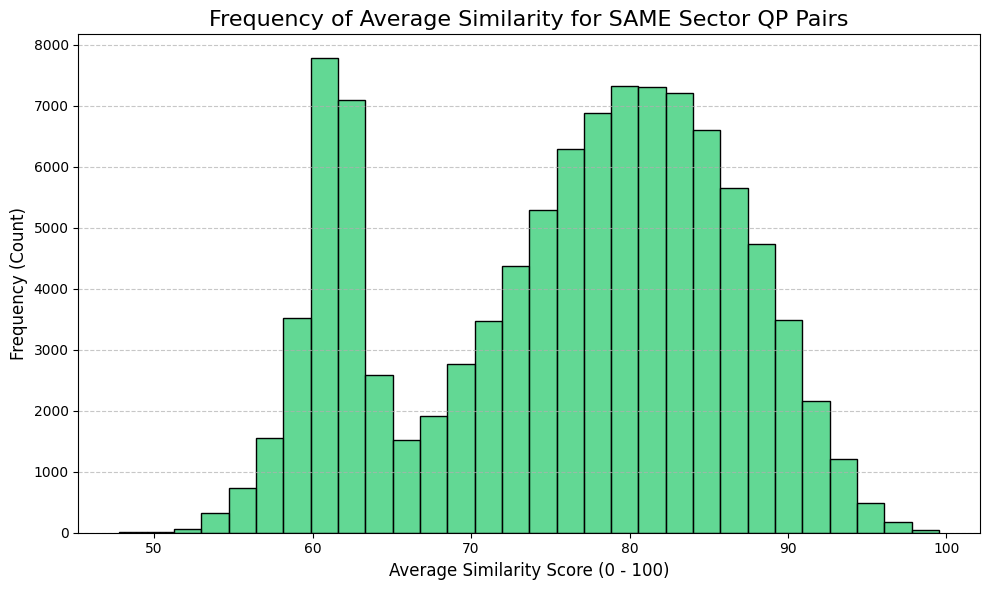

Plot generated: similarity_frequency_same_sector.png


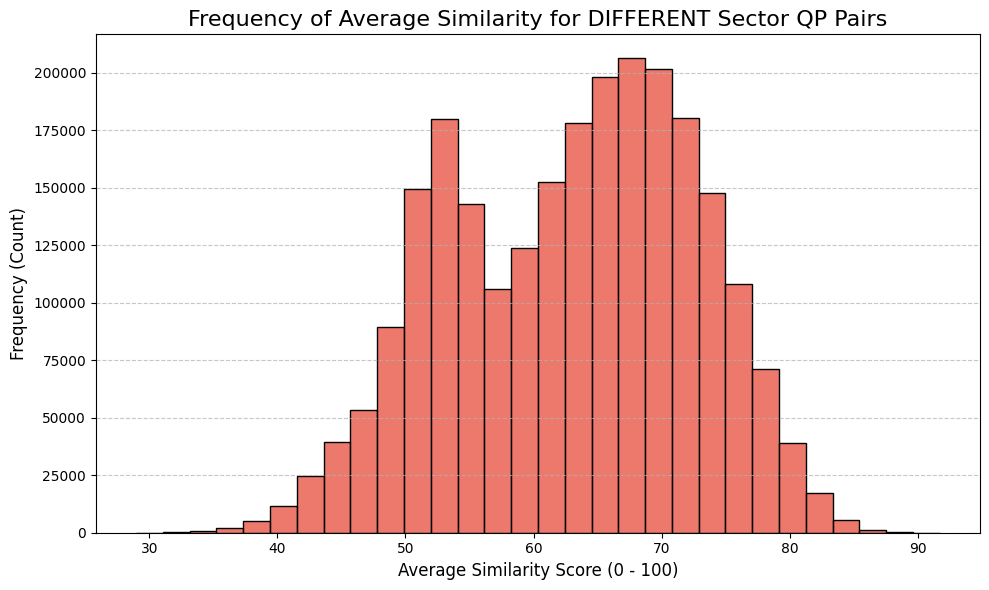

Plot generated: similarity_frequency_different_sector.png


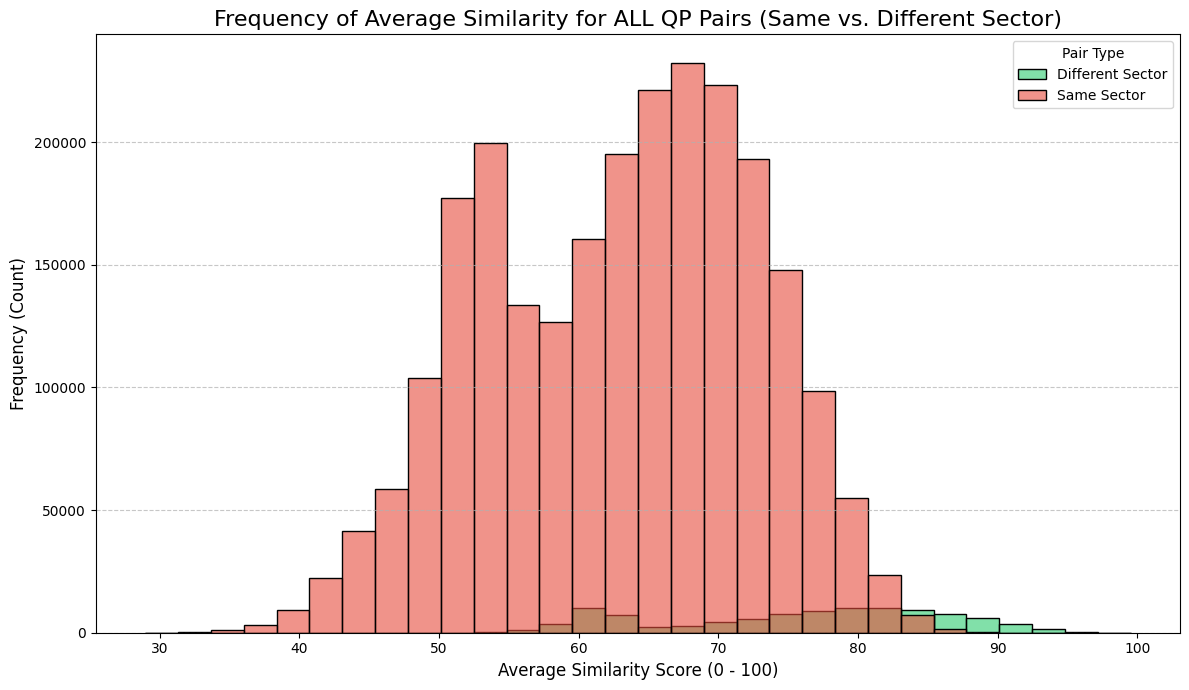

Plot generated: similarity_frequency_all_pairs.png


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Set a large display limit for Pandas DataFrames for diagnostics
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- CONFIGURATION ---
PARQUET_FILE = 'updated_all_similarities.paraquet'
CSV_FILE = 'qp-listings.csv'
OUTPUT_PLOT_SAME = 'similarity_frequency_same_sector.png'
OUTPUT_PLOT_DIFFERENT = 'similarity_frequency_different_sector.png'
OUTPUT_PLOT_ALL = 'similarity_frequency_all_pairs.png'

# --- DATA LOADING AND CLEANING ---

# 1. Load the datasets, handling potential filename variations
try:
    df_sim = pd.read_parquet(PARQUET_FILE)
except FileNotFoundError:
    df_sim = pd.read_parquet('updated_all_similarities.parquet')
    print(f"Loaded {PARQUET_FILE} with corrected extension.")

df_listings = pd.read_csv(CSV_FILE)
print("Data loaded successfully.")

# 2. Standardize a specific sector name
target_name = "Oï¬ƒce Administration & Facility Management"
new_name = "Administration & Facility Management"
df_listings['Sector Name'] = df_listings['Sector Name'].replace(target_name, new_name)

# 3. Calculate the combined average similarity score
# Embedding is scaled by 100, then averaged with the other two scores.
scaled_embedding = df_sim['embedding_similarity'] * 100
df_sim['average_similarity'] = (scaled_embedding + df_sim['task_similarity'] + df_sim['nsqf_level_similarity']) / 3


# --- QP CODE TO SECTOR MAPPING (The Waterfall Logic) ---

def generate_versioned_key(row):
    """Creates the 'qpCode_version.0' format for advanced matching."""
    code = str(row['qpCode'])
    version = str(row['qp_version'])
    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"

# Create all three potential matching keys
df_listings['match_key_1'] = df_listings['qpCode']
df_listings['match_key_2'] = df_listings.apply(generate_versioned_key, axis=1)
df_listings['match_key_3'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)

# Build the comprehensive master mapping dictionary
map_1 = df_listings[['match_key_1', 'Sector Name']].rename(columns={'match_key_1': 'join_key'})
map_2 = df_listings[['match_key_2', 'Sector Name']].rename(columns={'match_key_2': 'join_key'})
map_3 = df_listings[['match_key_3', 'Sector Name']].rename(columns={'match_key_3': 'join_key'})

master_map = pd.concat([map_1, map_2, map_3])
master_map = master_map.dropna(subset=['join_key'])
master_map = master_map[master_map['join_key'] != 'nan']
master_map = master_map.drop_duplicates(subset=['join_key'], keep='first')


# --- MERGING AND SECTOR CLASSIFICATION ---

# Merge to get the Sector names
df_merged = df_sim.merge(master_map, left_on='qp1_code', right_on='join_key', how='left').rename(columns={'Sector Name': 'Sector1'}).drop(columns=['join_key'])
df_merged = df_merged.merge(master_map, left_on='qp2_code', right_on='join_key', how='left').rename(columns={'Sector Name': 'Sector2'}).drop(columns=['join_key'])

# Filter out rows where sector mapping failed
df_clean = df_merged.dropna(subset=['Sector1', 'Sector2']).copy()

# Create the classification column
df_clean['is_same_sector'] = np.where(df_clean['Sector1'] == df_clean['Sector2'], 1, 0)
df_clean['sector_group'] = np.where(df_clean['is_same_sector'] == 1, 'Same Sector', 'Different Sector')


# --- PLOTTING (Filled Histograms) ---

def plot_similarity_frequency(data, title, filename, color):
    """Generates a filled histogram (frequency plot) for the similarity distribution."""
    plt.figure(figsize=(10, 6))

    # Use histplot for a filled histogram (frequency plot)
    # kde=False ensures only the histogram bars are shown
    # element="bars" is the default and creates the filled bars
    sns.histplot(data=data, x='average_similarity', kde=False, bins=30, color=color, edgecolor='black')

    plt.title(title, fontsize=16)
    plt.xlabel('Average Similarity Score (0 - 100)', fontsize=12)
    plt.ylabel('Frequency (Count)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Plot generated: {filename}")

# 1. Plot for Same Sector Pairs
df_same_sector = df_clean[df_clean['is_same_sector'] == 1]
plot_similarity_frequency(
    df_same_sector,
    'Frequency of Average Similarity for SAME Sector QP Pairs',
    OUTPUT_PLOT_SAME,
    '#2ecc71' # Green color
)

# 2. Plot for Different Sector Pairs
df_different_sector = df_clean[df_clean['is_same_sector'] == 0]
plot_similarity_frequency(
    df_different_sector,
    'Frequency of Average Similarity for DIFFERENT Sector QP Pairs',
    OUTPUT_PLOT_DIFFERENT,
    '#e74c3c' # Red color
)

# 3. Plot for All Pairs (Overlaid)
plt.figure(figsize=(12, 7))
# Overlays two filled histograms with transparency (alpha)
sns.histplot(
    data=df_clean,
    x='average_similarity',
    hue='sector_group',
    kde=False,
    bins=30,
    palette={'Same Sector': '#2ecc71', 'Different Sector': '#e74c3c'},
    alpha=0.6,
    edgecolor='black'
)
plt.title('Frequency of Average Similarity for ALL QP Pairs (Same vs. Different Sector)', fontsize=16)
plt.xlabel('Average Similarity Score (0 - 100)', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Pair Type', labels=['Different Sector', 'Same Sector'])
plt.tight_layout()
plt.savefig(OUTPUT_PLOT_ALL)
plt.show()
print(f"Plot generated: {OUTPUT_PLOT_ALL}")

Data loaded successfully.


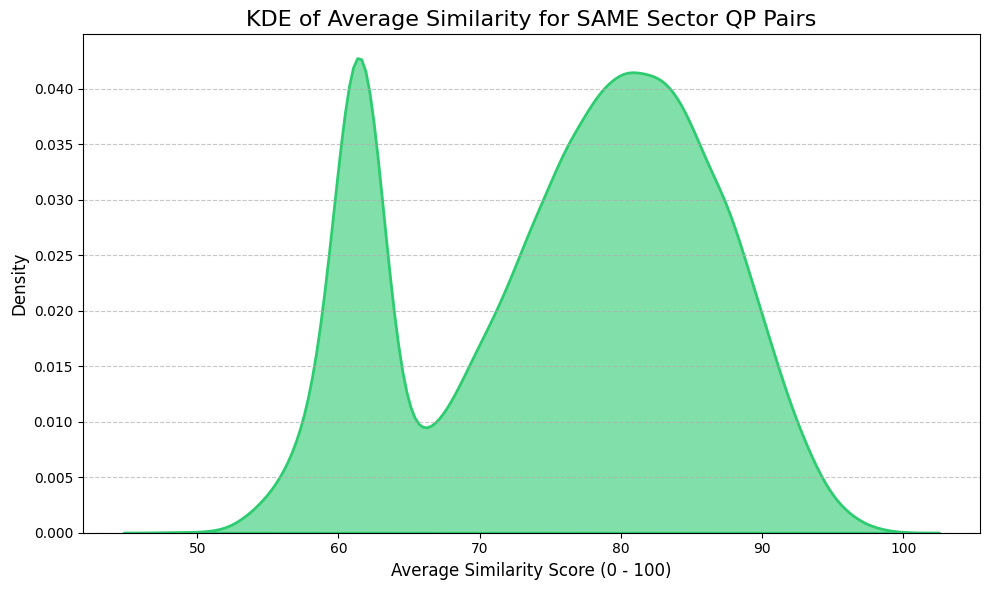

Plot generated: similarity_kde_same_sector.png


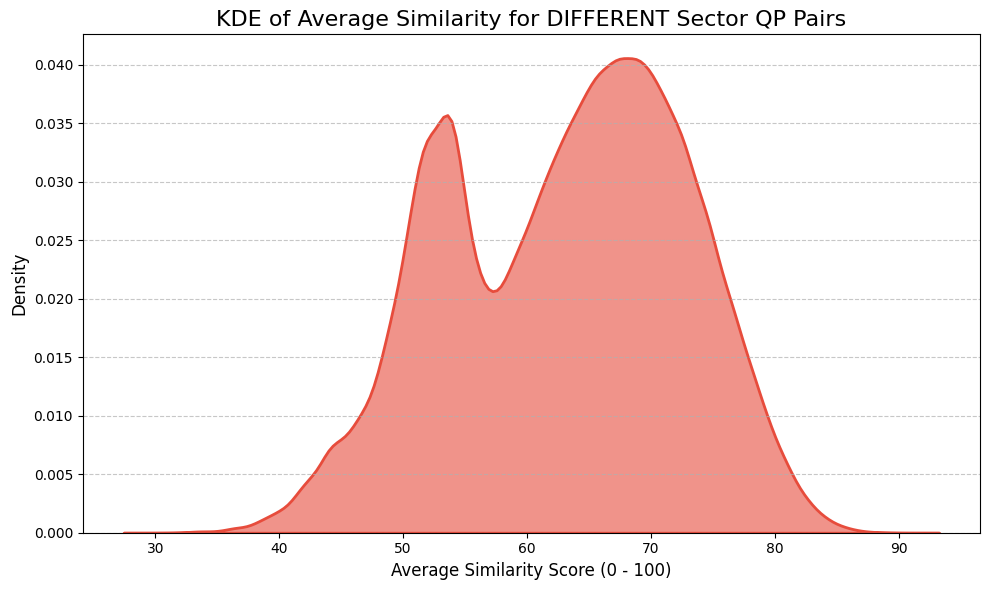

Plot generated: similarity_kde_different_sector.png


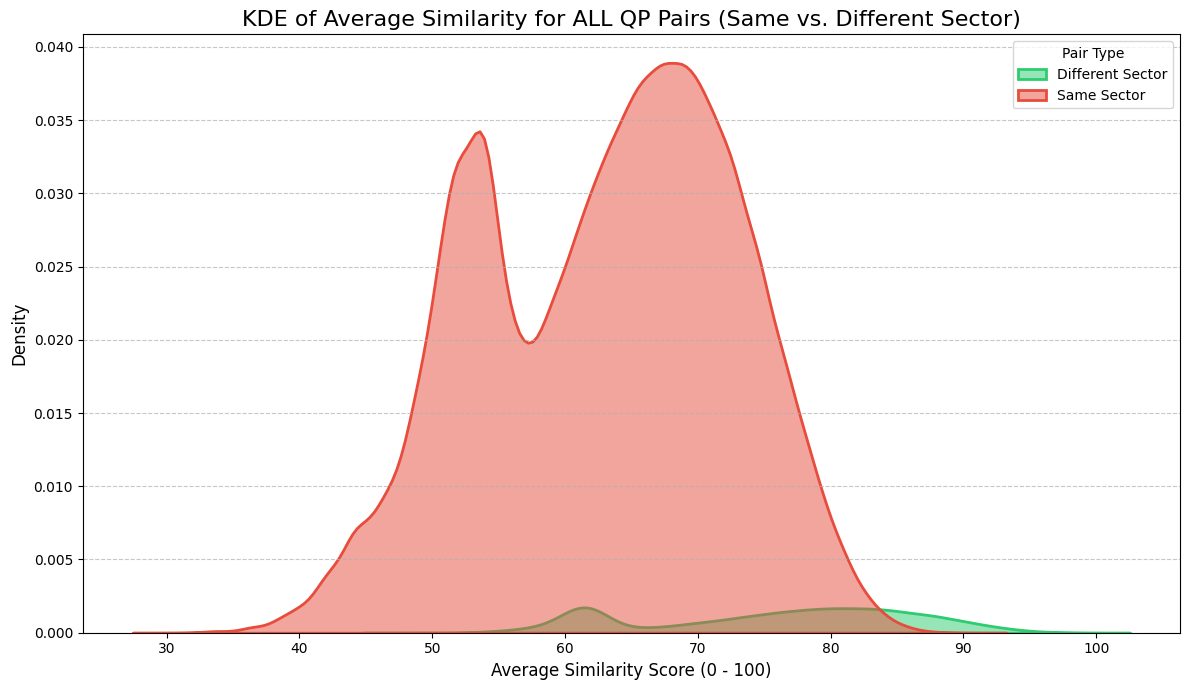

Plot generated: similarity_kde_all_pairs.png


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Set a large display limit for Pandas DataFrames for diagnostics
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- CONFIGURATION ---
PARQUET_FILE = 'updated_all_similarities.paraquet'
CSV_FILE = 'qp-listings.csv'
OUTPUT_PLOT_SAME = 'similarity_kde_same_sector.png'
OUTPUT_PLOT_DIFFERENT = 'similarity_kde_different_sector.png'
OUTPUT_PLOT_ALL = 'similarity_kde_all_pairs.png'

# --- DATA LOADING AND CLEANING ---

# 1. Load the datasets, handling potential filename variations
try:
    df_sim = pd.read_parquet(PARQUET_FILE)
except FileNotFoundError:
    df_sim = pd.read_parquet('updated_all_similarities.parquet')
    print(f"Loaded {PARQUET_FILE} with corrected extension.")

df_listings = pd.read_csv(CSV_FILE)
print("Data loaded successfully.")

# 2. Standardize a specific sector name
target_name = "Oï¬ƒce Administration & Facility Management"
new_name = "Administration & Facility Management"
df_listings['Sector Name'] = df_listings['Sector Name'].replace(target_name, new_name)

# 3. Calculate the combined average similarity score
# Embedding is scaled by 100, then averaged with the other two scores.
scaled_embedding = df_sim['embedding_similarity'] * 100
df_sim['average_similarity'] = (scaled_embedding + df_sim['task_similarity'] + df_sim['nsqf_level_similarity']) / 3


# --- QP CODE TO SECTOR MAPPING (The Waterfall Logic) ---

def generate_versioned_key(row):
    """Creates the 'qpCode_version.0' format for advanced matching."""
    code = str(row['qpCode'])
    version = str(row['qp_version'])
    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"

# Create all three potential matching keys
df_listings['match_key_1'] = df_listings['qpCode']
df_listings['match_key_2'] = df_listings.apply(generate_versioned_key, axis=1)
df_listings['match_key_3'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)

# Build the comprehensive master mapping dictionary
map_1 = df_listings[['match_key_1', 'Sector Name']].rename(columns={'match_key_1': 'join_key'})
map_2 = df_listings[['match_key_2', 'Sector Name']].rename(columns={'match_key_2': 'join_key'})
map_3 = df_listings[['match_key_3', 'Sector Name']].rename(columns={'match_key_3': 'join_key'})

master_map = pd.concat([map_1, map_2, map_3])
master_map = master_map.dropna(subset=['join_key'])
master_map = master_map[master_map['join_key'] != 'nan']
master_map = master_map.drop_duplicates(subset=['join_key'], keep='first')


# --- MERGING AND SECTOR CLASSIFICATION ---

# Merge to get the Sector names
df_merged = df_sim.merge(master_map, left_on='qp1_code', right_on='join_key', how='left').rename(columns={'Sector Name': 'Sector1'}).drop(columns=['join_key'])
df_merged = df_merged.merge(master_map, left_on='qp2_code', right_on='join_key', how='left').rename(columns={'Sector Name': 'Sector2'}).drop(columns=['join_key'])

# Filter out rows where sector mapping failed
df_clean = df_merged.dropna(subset=['Sector1', 'Sector2']).copy()

# Create the classification column
df_clean['is_same_sector'] = np.where(df_clean['Sector1'] == df_clean['Sector2'], 1, 0)
df_clean['sector_group'] = np.where(df_clean['is_same_sector'] == 1, 'Same Sector', 'Different Sector')


# --- PLOTTING (Filled KDE Curves) ---

def plot_similarity_kde(data, title, filename, color):
    """Generates a filled KDE curve for the similarity distribution."""
    plt.figure(figsize=(10, 6))

    # Use kdeplot with fill=True for a filled curve
    sns.kdeplot(data=data, x='average_similarity', fill=True, color=color, alpha=0.6, linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel('Average Similarity Score (0 - 100)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Plot generated: {filename}")

# 1. Plot for Same Sector Pairs
df_same_sector = df_clean[df_clean['is_same_sector'] == 1]
plot_similarity_kde(
    df_same_sector,
    'KDE of Average Similarity for SAME Sector QP Pairs',
    OUTPUT_PLOT_SAME,
    '#2ecc71' # Green color
)

# 2. Plot for Different Sector Pairs
df_different_sector = df_clean[df_clean['is_same_sector'] == 0]
plot_similarity_kde(
    df_different_sector,
    'KDE of Average Similarity for DIFFERENT Sector QP Pairs',
    OUTPUT_PLOT_DIFFERENT,
    '#e74c3c' # Red color
)

# 3. Plot for All Pairs (Overlaid)
plt.figure(figsize=(12, 7))
# Overlays two filled KDE plots with transparency (alpha)
sns.kdeplot(
    data=df_clean,
    x='average_similarity',
    hue='sector_group',
    fill=True,
    palette={'Same Sector': '#2ecc71', 'Different Sector': '#e74c3c'},
    alpha=0.5,
    linewidth=2
)
plt.title('KDE of Average Similarity for ALL QP Pairs (Same vs. Different Sector)', fontsize=16)
plt.xlabel('Average Similarity Score (0 - 100)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Pair Type', labels=['Different Sector', 'Same Sector'])
plt.tight_layout()
plt.savefig(OUTPUT_PLOT_ALL)
plt.show()
print(f"Plot generated: {OUTPUT_PLOT_ALL}")

Data loaded successfully.


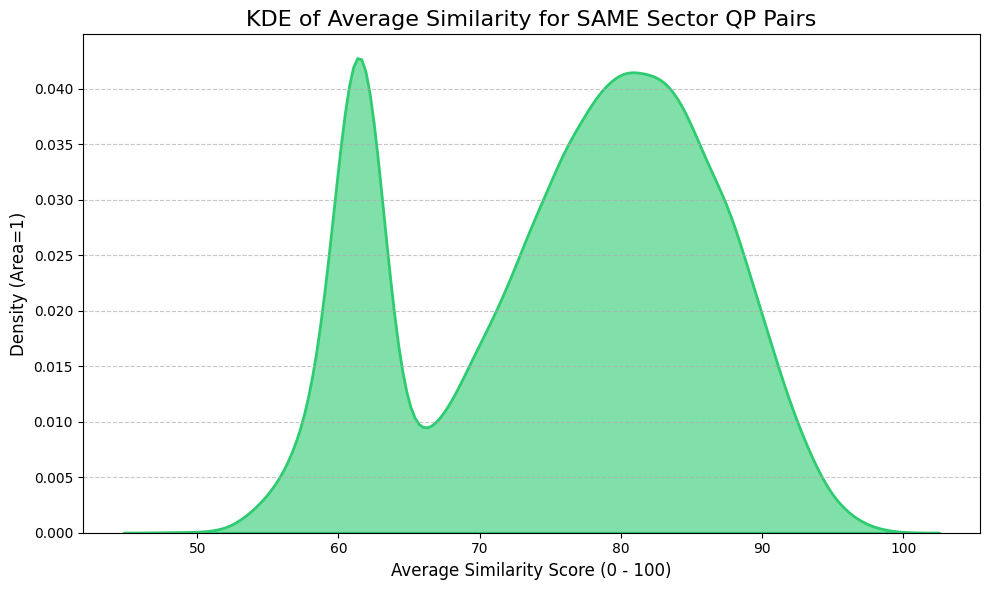

Plot generated: similarity_kde_same_sector.png


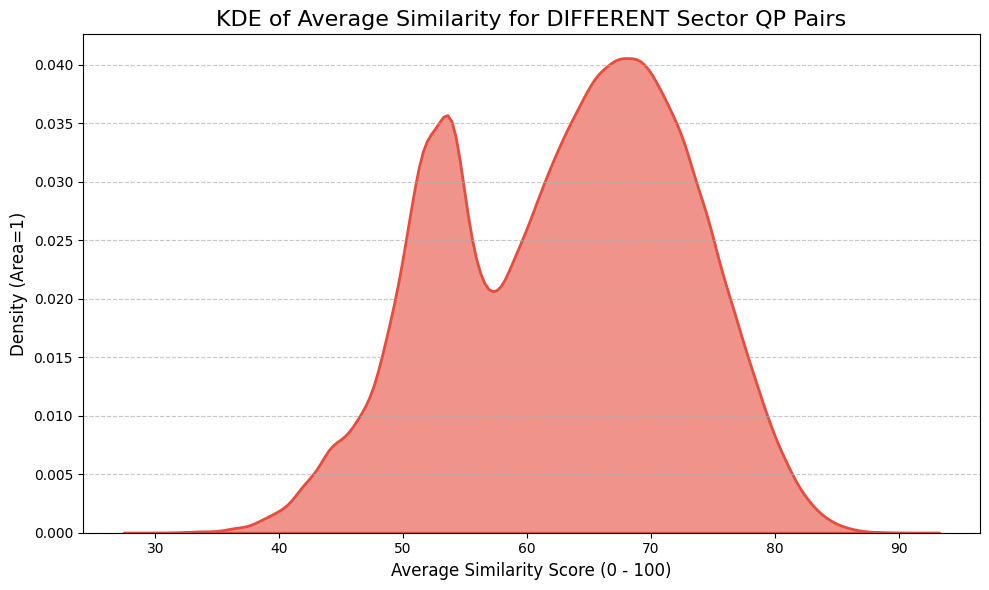

Plot generated: similarity_kde_different_sector.png


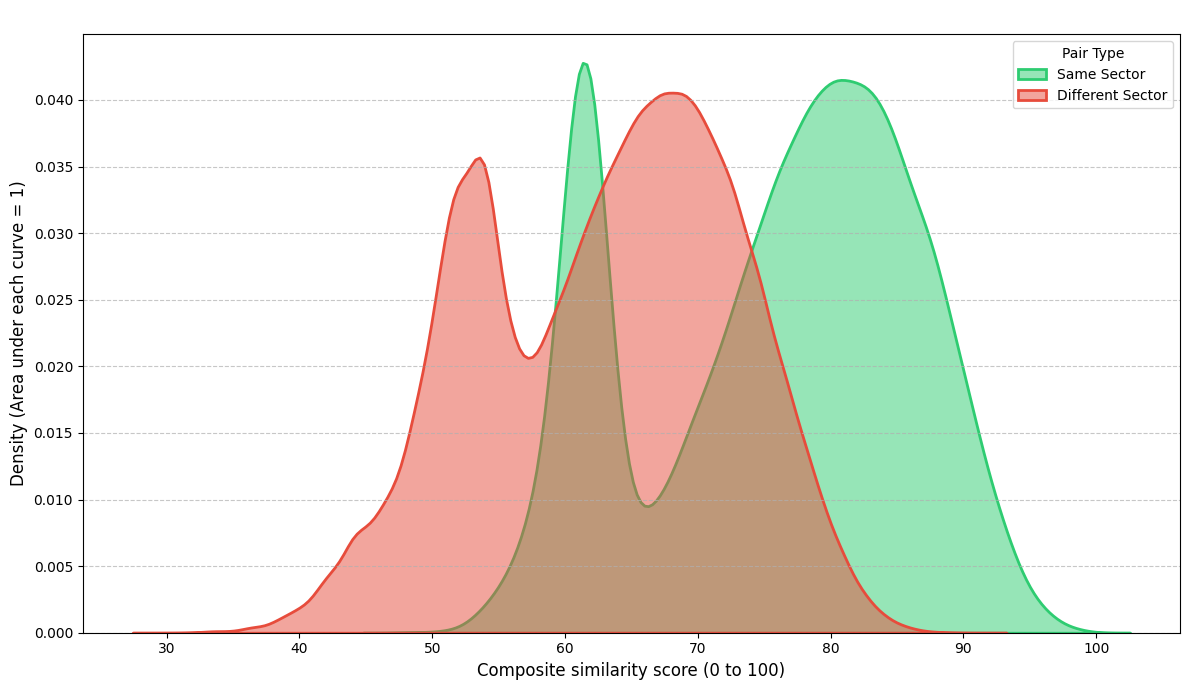

Plot generated: similarity_kde_all_pairs_individually_normalized.png


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Set a large display limit for Pandas DataFrames for diagnostics
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- CONFIGURATION ---
PARQUET_FILE = 'updated_all_similarities.paraquet'
CSV_FILE = 'qp-listings.csv'
OUTPUT_PLOT_SAME = 'similarity_kde_same_sector.png'
OUTPUT_PLOT_DIFFERENT = 'similarity_kde_different_sector.png'
OUTPUT_PLOT_ALL_INDIVIDUAL_NORMALIZED = 'similarity_kde_all_pairs_individually_normalized.png' # Changed filename

# --- DATA LOADING AND CLEANING ---

# 1. Load the datasets, handling potential filename variations
try:
    df_sim = pd.read_parquet(PARQUET_FILE)
except FileNotFoundError:
    df_sim = pd.read_parquet('updated_all_similarities.parquet')
    print(f"Loaded {PARQUET_FILE} with corrected extension.")

df_listings = pd.read_csv(CSV_FILE)
print("Data loaded successfully.")

# 2. Standardize a specific sector name
target_name = "Oï¬ƒce Administration & Facility Management"
new_name = "Administration & Facility Management"
df_listings['Sector Name'] = df_listings['Sector Name'].replace(target_name, new_name)

# 3. Calculate the combined average similarity score
# Embedding is scaled by 100, then averaged with the other two scores.
scaled_embedding = df_sim['embedding_similarity'] * 100
df_sim['average_similarity'] = (scaled_embedding + df_sim['task_similarity'] + df_sim['nsqf_level_similarity']) / 3


# --- QP CODE TO SECTOR MAPPING (The Waterfall Logic) ---

def generate_versioned_key(row):
    """Creates the 'qpCode_version.0' format for advanced matching."""
    code = str(row['qpCode'])
    version = str(row['qp_version'])
    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"

# Create all three potential matching keys
df_listings['match_key_1'] = df_listings['qpCode']
df_listings['match_key_2'] = df_listings.apply(generate_versioned_key, axis=1)
df_listings['match_key_3'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)

# Build the comprehensive master mapping dictionary
map_1 = df_listings[['match_key_1', 'Sector Name']].rename(columns={'match_key_1': 'join_key'})
map_2 = df_listings[['match_key_2', 'Sector Name']].rename(columns={'match_key_2': 'join_key'})
map_3 = df_listings[['match_key_3', 'Sector Name']].rename(columns={'match_key_3': 'join_key'})

master_map = pd.concat([map_1, map_2, map_3])
master_map = master_map.dropna(subset=['join_key'])
master_map = master_map[master_map['join_key'] != 'nan']
master_map = master_map.drop_duplicates(subset=['join_key'], keep='first')


# --- MERGING AND SECTOR CLASSIFICATION ---

# Merge to get the Sector names
df_merged = df_sim.merge(master_map, left_on='qp1_code', right_on='join_key', how='left').rename(columns={'Sector Name': 'Sector1'}).drop(columns=['join_key'])
df_merged = df_merged.merge(master_map, left_on='qp2_code', right_on='join_key', how='left').rename(columns={'Sector Name': 'Sector2'}).drop(columns=['join_key'])

# Filter out rows where sector mapping failed
df_clean = df_merged.dropna(subset=['Sector1', 'Sector2']).copy()

# Create the classification column
df_clean['is_same_sector'] = np.where(df_clean['Sector1'] == df_clean['Sector2'], 1, 0)
df_clean['sector_group'] = np.where(df_clean['is_same_sector'] == 1, 'Same Sector', 'Different Sector')

# --- PRE-FILTERING FOR PLOTS ---
df_same_sector = df_clean[df_clean['is_same_sector'] == 1]
df_different_sector = df_clean[df_clean['is_same_sector'] == 0]

# --- PLOTTING (Filled KDE Curves) ---

def plot_similarity_kde(data, title, filename, color):
    """Generates a filled KDE curve for the similarity distribution (Area=1)."""
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=data, x='average_similarity', fill=True, color=color, alpha=0.6, linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel('Average Similarity Score (0 - 100)', fontsize=12)
    plt.ylabel('Density (Area=1)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Plot generated: {filename}")


# 1. Plot for Same Sector Pairs
plot_similarity_kde(
    df_same_sector,
    'KDE of Average Similarity for SAME Sector QP Pairs',
    OUTPUT_PLOT_SAME,
    '#2ecc71' # Green color
)

# 2. Plot for Different Sector Pairs
plot_similarity_kde(
    df_different_sector,
    'KDE of Average Similarity for DIFFERENT Sector QP Pairs',
    OUTPUT_PLOT_DIFFERENT,
    '#e74c3c' # Red color
)


# 3. PLOT FOR ALL PAIRS (INDIVIDUALLY NORMALIZED) 🏆
# This section ensures each curve's area integrates to 1, resolving the visual size issue.
plt.figure(figsize=(12, 7))

# Plot the Same Sector distribution
sns.kdeplot(
    data=df_same_sector,
    x='average_similarity',
    fill=True,
    color='#2ecc71',
    alpha=0.5,
    linewidth=2,
    label='Same Sector'
)

# Plot the Different Sector distribution
sns.kdeplot(
    data=df_different_sector,
    x='average_similarity',
    fill=True,
    color='#e74c3c',
    alpha=0.5,
    linewidth=2,
    label='Different Sector'
)

plt.title('  ', fontsize=16)
plt.xlabel('Composite similarity score (0 to 100)', fontsize=12)
plt.ylabel('Density (Area under each curve = 1)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Pair Type')
plt.tight_layout()
plt.savefig(OUTPUT_PLOT_ALL_INDIVIDUAL_NORMALIZED)
plt.show()
print(f"Plot generated: {OUTPUT_PLOT_ALL_INDIVIDUAL_NORMALIZED}")

Checking for zeros

Loading data...
Standardizing Sector Names...
Generating match keys...
Merging Sector data into Similarities...
Building Matrix...
Plotting Heatmap...
Heatmap generated: sector_similarity_heatmap_final.png

--- DIAGNOSTIC CHECK FOR TARGET SECTORS ---
Sector 'Administration & Facility Management': Total Similarity Interaction = 0.0000 (If 0.0000, no matches found)
Sector 'Paper & Paper Products': Total Similarity Interaction = 0.0000 (If 0.0000, no matches found)
Consolidated table generated: sector_similarity_table_final.csv


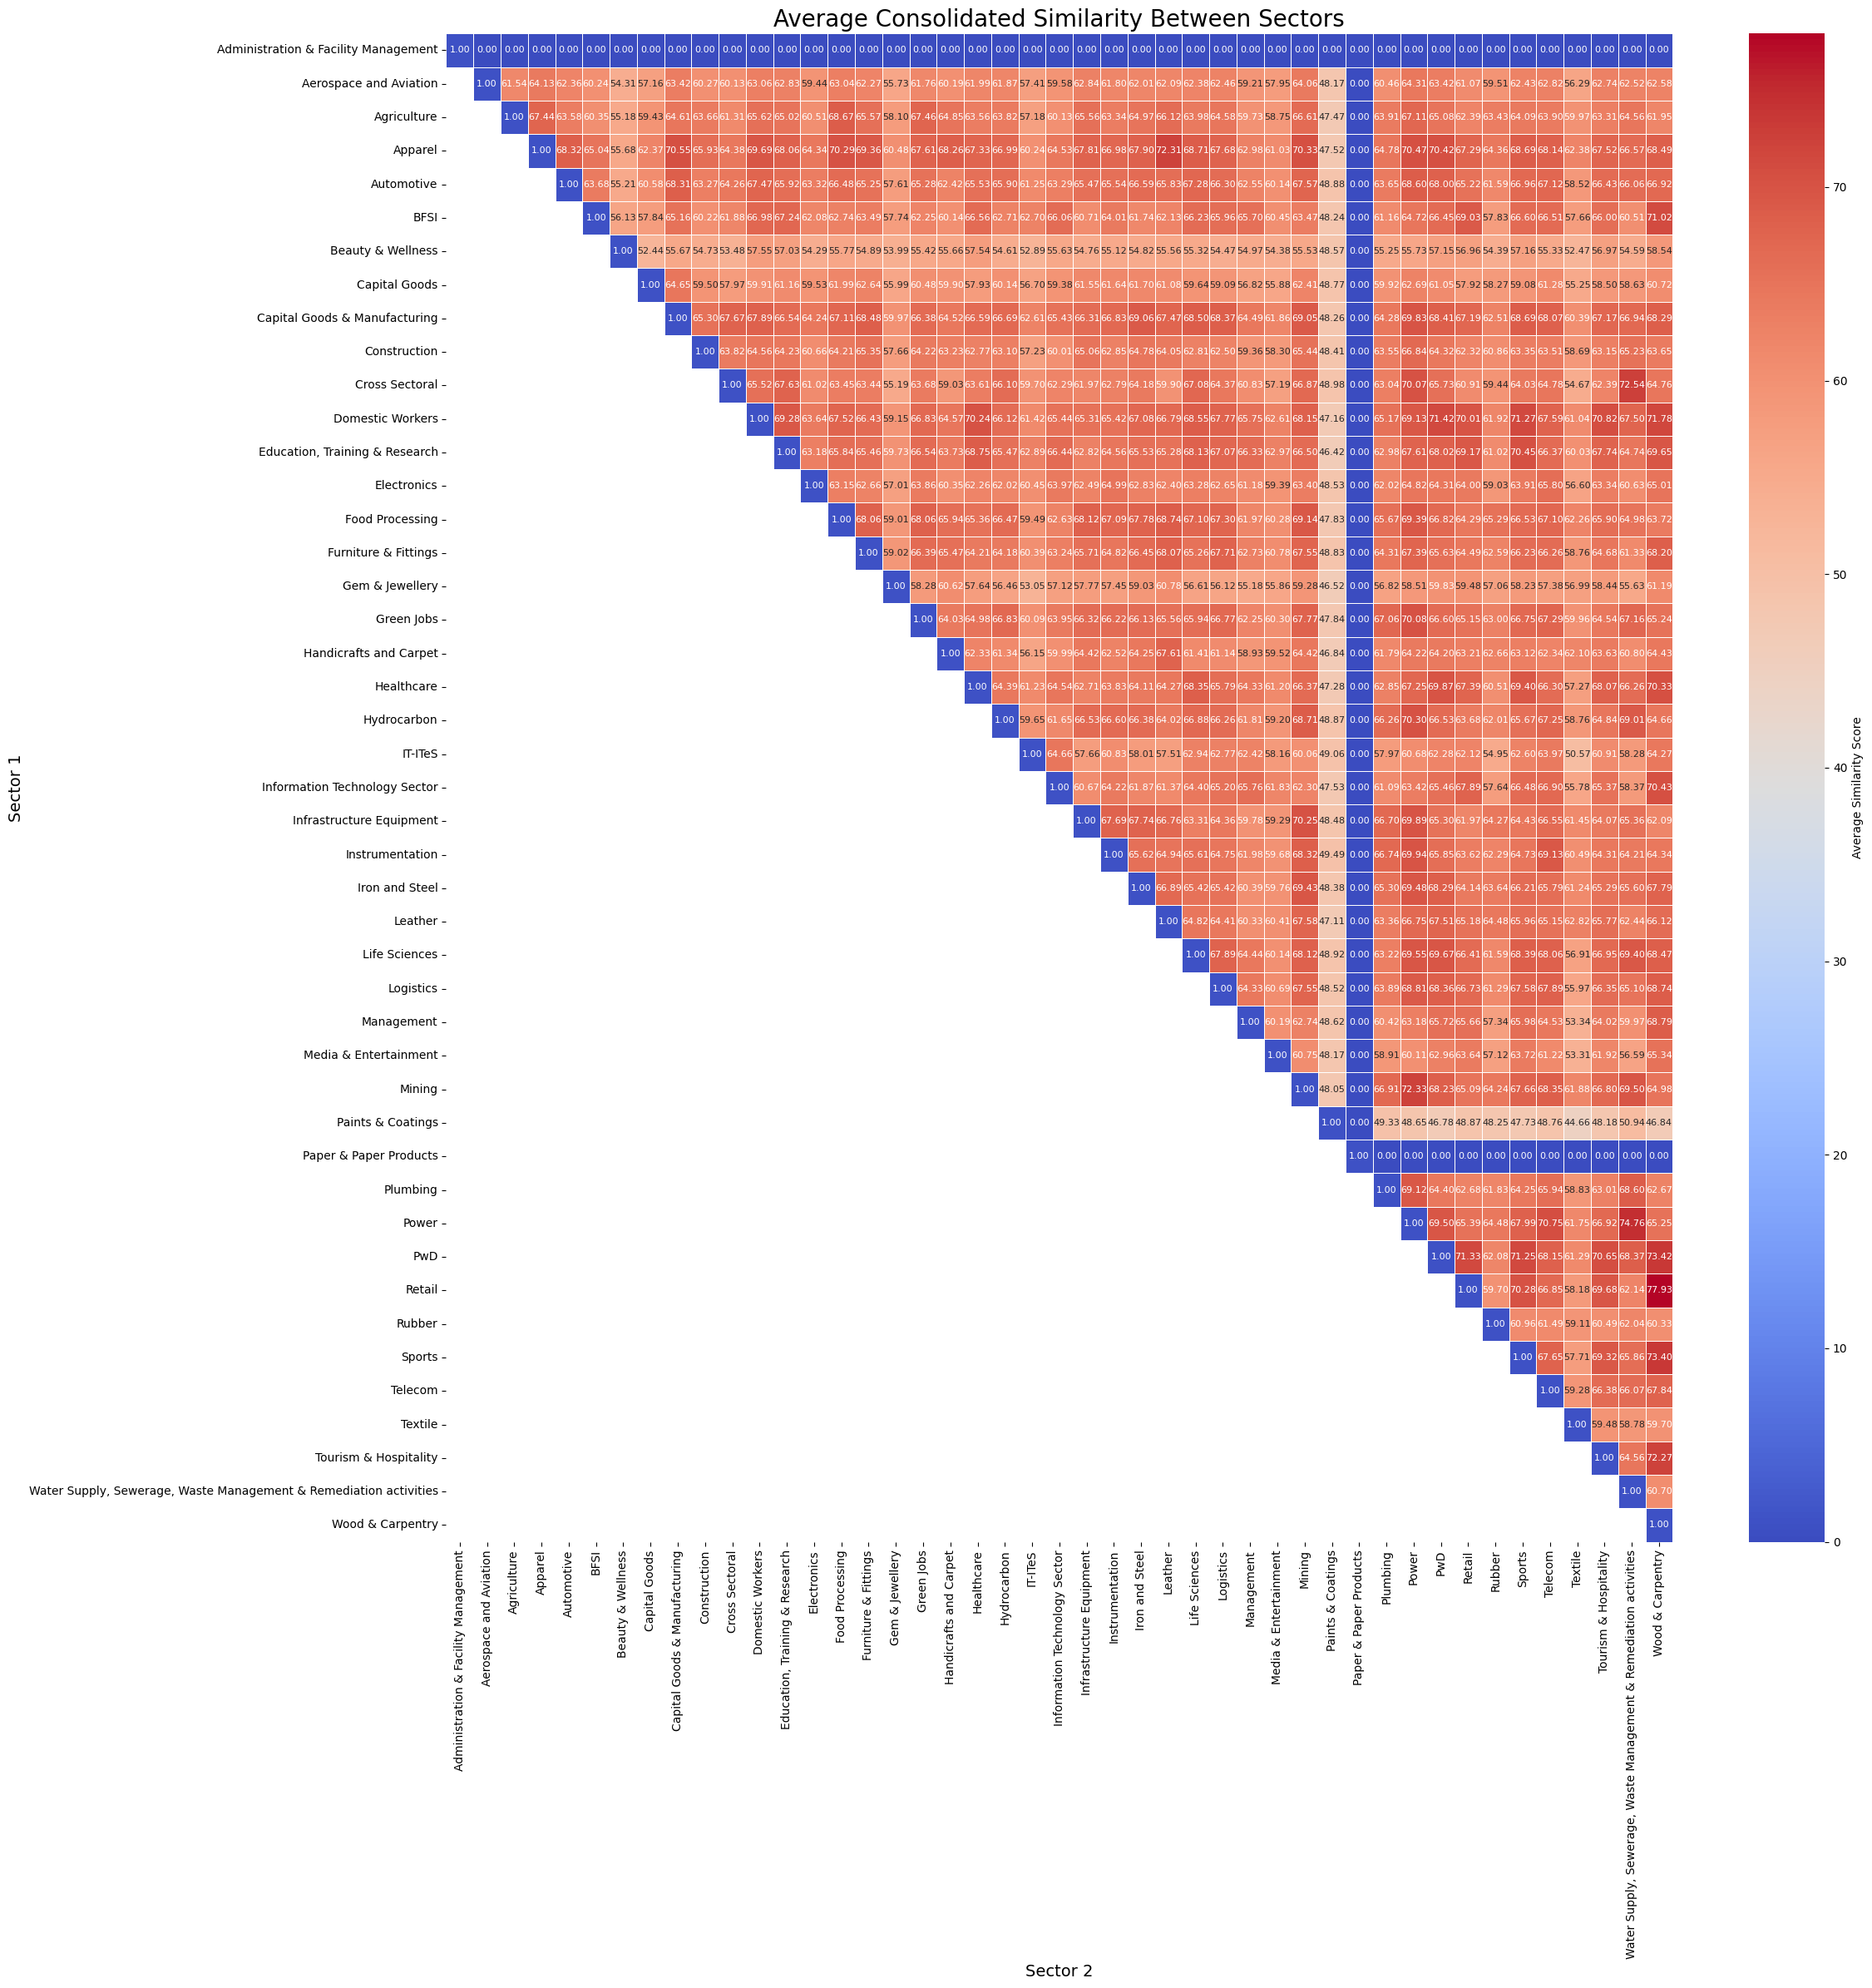

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Set a large display limit for Pandas DataFrames for diagnostics
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- CONFIGURATION ---
PARQUET_FILE = 'all_similarities.paraquet' # Checks for .parquet as fallback below
CSV_FILE = 'qp-listings.csv'
OUTPUT_HEATMAP = 'sector_similarity_heatmap_final.png'
OUTPUT_TABLE = 'sector_similarity_table_final.csv'

# --- DATA LOADING ---
print("Loading data...")

# 1. Load the datasets, handling potential filename variations
if os.path.exists(PARQUET_FILE):
    df_sim = pd.read_parquet(PARQUET_FILE)
elif os.path.exists('all_similarities.parquet'):
    df_sim = pd.read_parquet('all_similarities.parquet')
else:
    raise FileNotFoundError("Could not find all_similarities.paraquet or .parquet")

df_listings = pd.read_csv(CSV_FILE)

# --- CLEANING & FIXES (CRITICAL SECTION) ---

# FIX 1: Robust Sector Renaming
# We use str.contains to bypass encoding issues (like the 'ï¬ƒ' ligature)
print("Standardizing Sector Names...")
admin_mask = df_listings['Sector Name'].str.contains("Administration & Facility", case=False, na=False)
df_listings.loc[admin_mask, 'Sector Name'] = "Administration & Facility Management"

# FIX 2: Whitespace and Type Cleaning
# Ensure all join keys are clean strings (no hidden spaces)
df_listings['qpCode'] = df_listings['qpCode'].astype(str).str.strip()
df_listings['qp_version'] = df_listings['qp_version'].astype(str).str.strip()
df_listings['matched_filename'] = df_listings['matched_filename'].astype(str).str.strip()

# Clean the similarity dataframe keys as well to ensure matching works
df_sim['qp1_code'] = df_sim['qp1_code'].astype(str).str.strip()
df_sim['qp2_code'] = df_sim['qp2_code'].astype(str).str.strip()

# 3. Calculate the combined average similarity score
# (Your updated logic: Embedding*100 averaged with others)
scaled_embedding = df_sim['embedding_similarity'] * 100
df_sim['average_similarity'] = (scaled_embedding + df_sim['task_similarity'] + df_sim['nsqf_level_similarity']) / 3

# --- QP CODE TO SECTOR MAPPING (The Waterfall Logic) ---

def generate_versioned_key(row):
    """Creates the 'qpCode_version.0' format for advanced matching."""
    code = row['qpCode'] # Already stripped above
    version = row['qp_version'] # Already stripped above

    if version == 'nan': return np.nan

    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"

print("Generating match keys...")
# Create all three potential matching keys in the listing data
df_listings['match_key_1'] = df_listings['qpCode']
df_listings['match_key_2'] = df_listings.apply(generate_versioned_key, axis=1)
df_listings['match_key_3'] = df_listings['matched_filename'].str.replace('.json', '', regex=False)

# Build the comprehensive master mapping dictionary
map_1 = df_listings[['match_key_1', 'Sector Name']].rename(columns={'match_key_1': 'join_key'})
map_2 = df_listings[['match_key_2', 'Sector Name']].rename(columns={'match_key_2': 'join_key'})
map_3 = df_listings[['match_key_3', 'Sector Name']].rename(columns={'match_key_3': 'join_key'})

master_map = pd.concat([map_1, map_2, map_3])
master_map = master_map.dropna(subset=['join_key'])
master_map = master_map[master_map['join_key'] != 'nan']
# Remove duplicates to prevent fan-out during merge
master_map = master_map.drop_duplicates(subset=['join_key'])

# --- MERGING AND CONSOLIDATION ---

print("Merging Sector data into Similarities...")
# Merge to get the raw Sector names for both QP codes
df_merged = df_sim.merge(master_map, left_on='qp1_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'RawSector1'}).drop(columns=['join_key'])

df_merged = df_merged.merge(master_map, left_on='qp2_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'RawSector2'}).drop(columns=['join_key'])

# Filter out rows where sector mapping failed
df_clean = df_merged.dropna(subset=['RawSector1', 'RawSector2']).copy()

def consolidate_sectors(row):
    """Sorts the two sector names alphabetically to create a canonical pair key."""
    s1 = row['RawSector1']
    s2 = row['RawSector2']
    return pd.Series(sorted((s1, s2)), index=['Sector1', 'Sector2'])

# Apply the consolidation logic
df_clean[['Sector1', 'Sector2']] = df_clean.apply(consolidate_sectors, axis=1)

# --- MATRIX CREATION AND SYMMETRIZATION ---

print("Building Matrix...")
# 1. Calculate the Consolidated Average
heatmap_data = df_clean.groupby(['Sector1', 'Sector2'])['average_similarity'].mean().reset_index()

# 2. Pivot the data to a matrix form
heatmap_matrix = heatmap_data.pivot(index='Sector1', columns='Sector2', values='average_similarity')

# 3. Get the complete list of sectors from LISTINGS (to ensure Paper/Admin appear even if low data)
all_sectors = sorted(df_listings['Sector Name'].dropna().unique())

# 4. Reindex to ensure square matrix
heatmap_matrix = heatmap_matrix.reindex(index=all_sectors, columns=all_sectors)

# 5. Mirror the data to make the matrix symmetric
symmetric_matrix = heatmap_matrix.fillna(0) + heatmap_matrix.T.fillna(0)
final_matrix = symmetric_matrix.mask(symmetric_matrix == 0, heatmap_matrix)
final_matrix = final_matrix.fillna(0)

# 6. Apply self-similarity = 1.0 (Diagonal)
np.fill_diagonal(final_matrix.values, 1.0)
# Note: If you have real self-similarity data > 0, you can use:
# np.fill_diagonal(final_matrix.values, np.maximum(np.diag(final_matrix.values), 1.0))

# --- HEATMAP GENERATION ---

print("Plotting Heatmap...")
plt.figure(figsize=(24, 24))

# Create mask for the LOWER triangle (keeps diagonal and upper triangle visible)
mask = np.tril(np.ones_like(final_matrix, dtype=bool), k=-1)

sns.heatmap(final_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=.5, cbar_kws={'label': 'Average Similarity Score'},
            annot_kws={"size": 8})

plt.title('Average Consolidated Similarity Between Sectors', fontsize=20)
plt.xlabel('Sector 2', fontsize=14)
plt.ylabel('Sector 1', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

plt.savefig(OUTPUT_HEATMAP)
print(f"Heatmap generated: {OUTPUT_HEATMAP}")

# --- DIAGNOSTIC CHECK ---
# This prints to console to confirm if Paper/Admin have values now
print("\n--- DIAGNOSTIC CHECK FOR TARGET SECTORS ---")
target_check = ["Administration & Facility Management", "Paper & Paper Products"]
for sec in target_check:
    if sec in final_matrix.index:
        # Check sum of similarities (excluding self-diagonal) to see if it interacted with anything
        row_sum = final_matrix.loc[sec].sum() - 1.0
        print(f"Sector '{sec}': Total Similarity Interaction = {row_sum:.4f} (If 0.0000, no matches found)")
    else:
        print(f"Sector '{sec}': NOT FOUND in Matrix Index")

# --- SAVE TABLE ---
similarity_table = heatmap_data.sort_values(by='average_similarity', ascending=False)
similarity_table.to_csv(OUTPUT_TABLE, index=False)
print(f"Consolidated table generated: {OUTPUT_TABLE}")

Considering only skill similarities

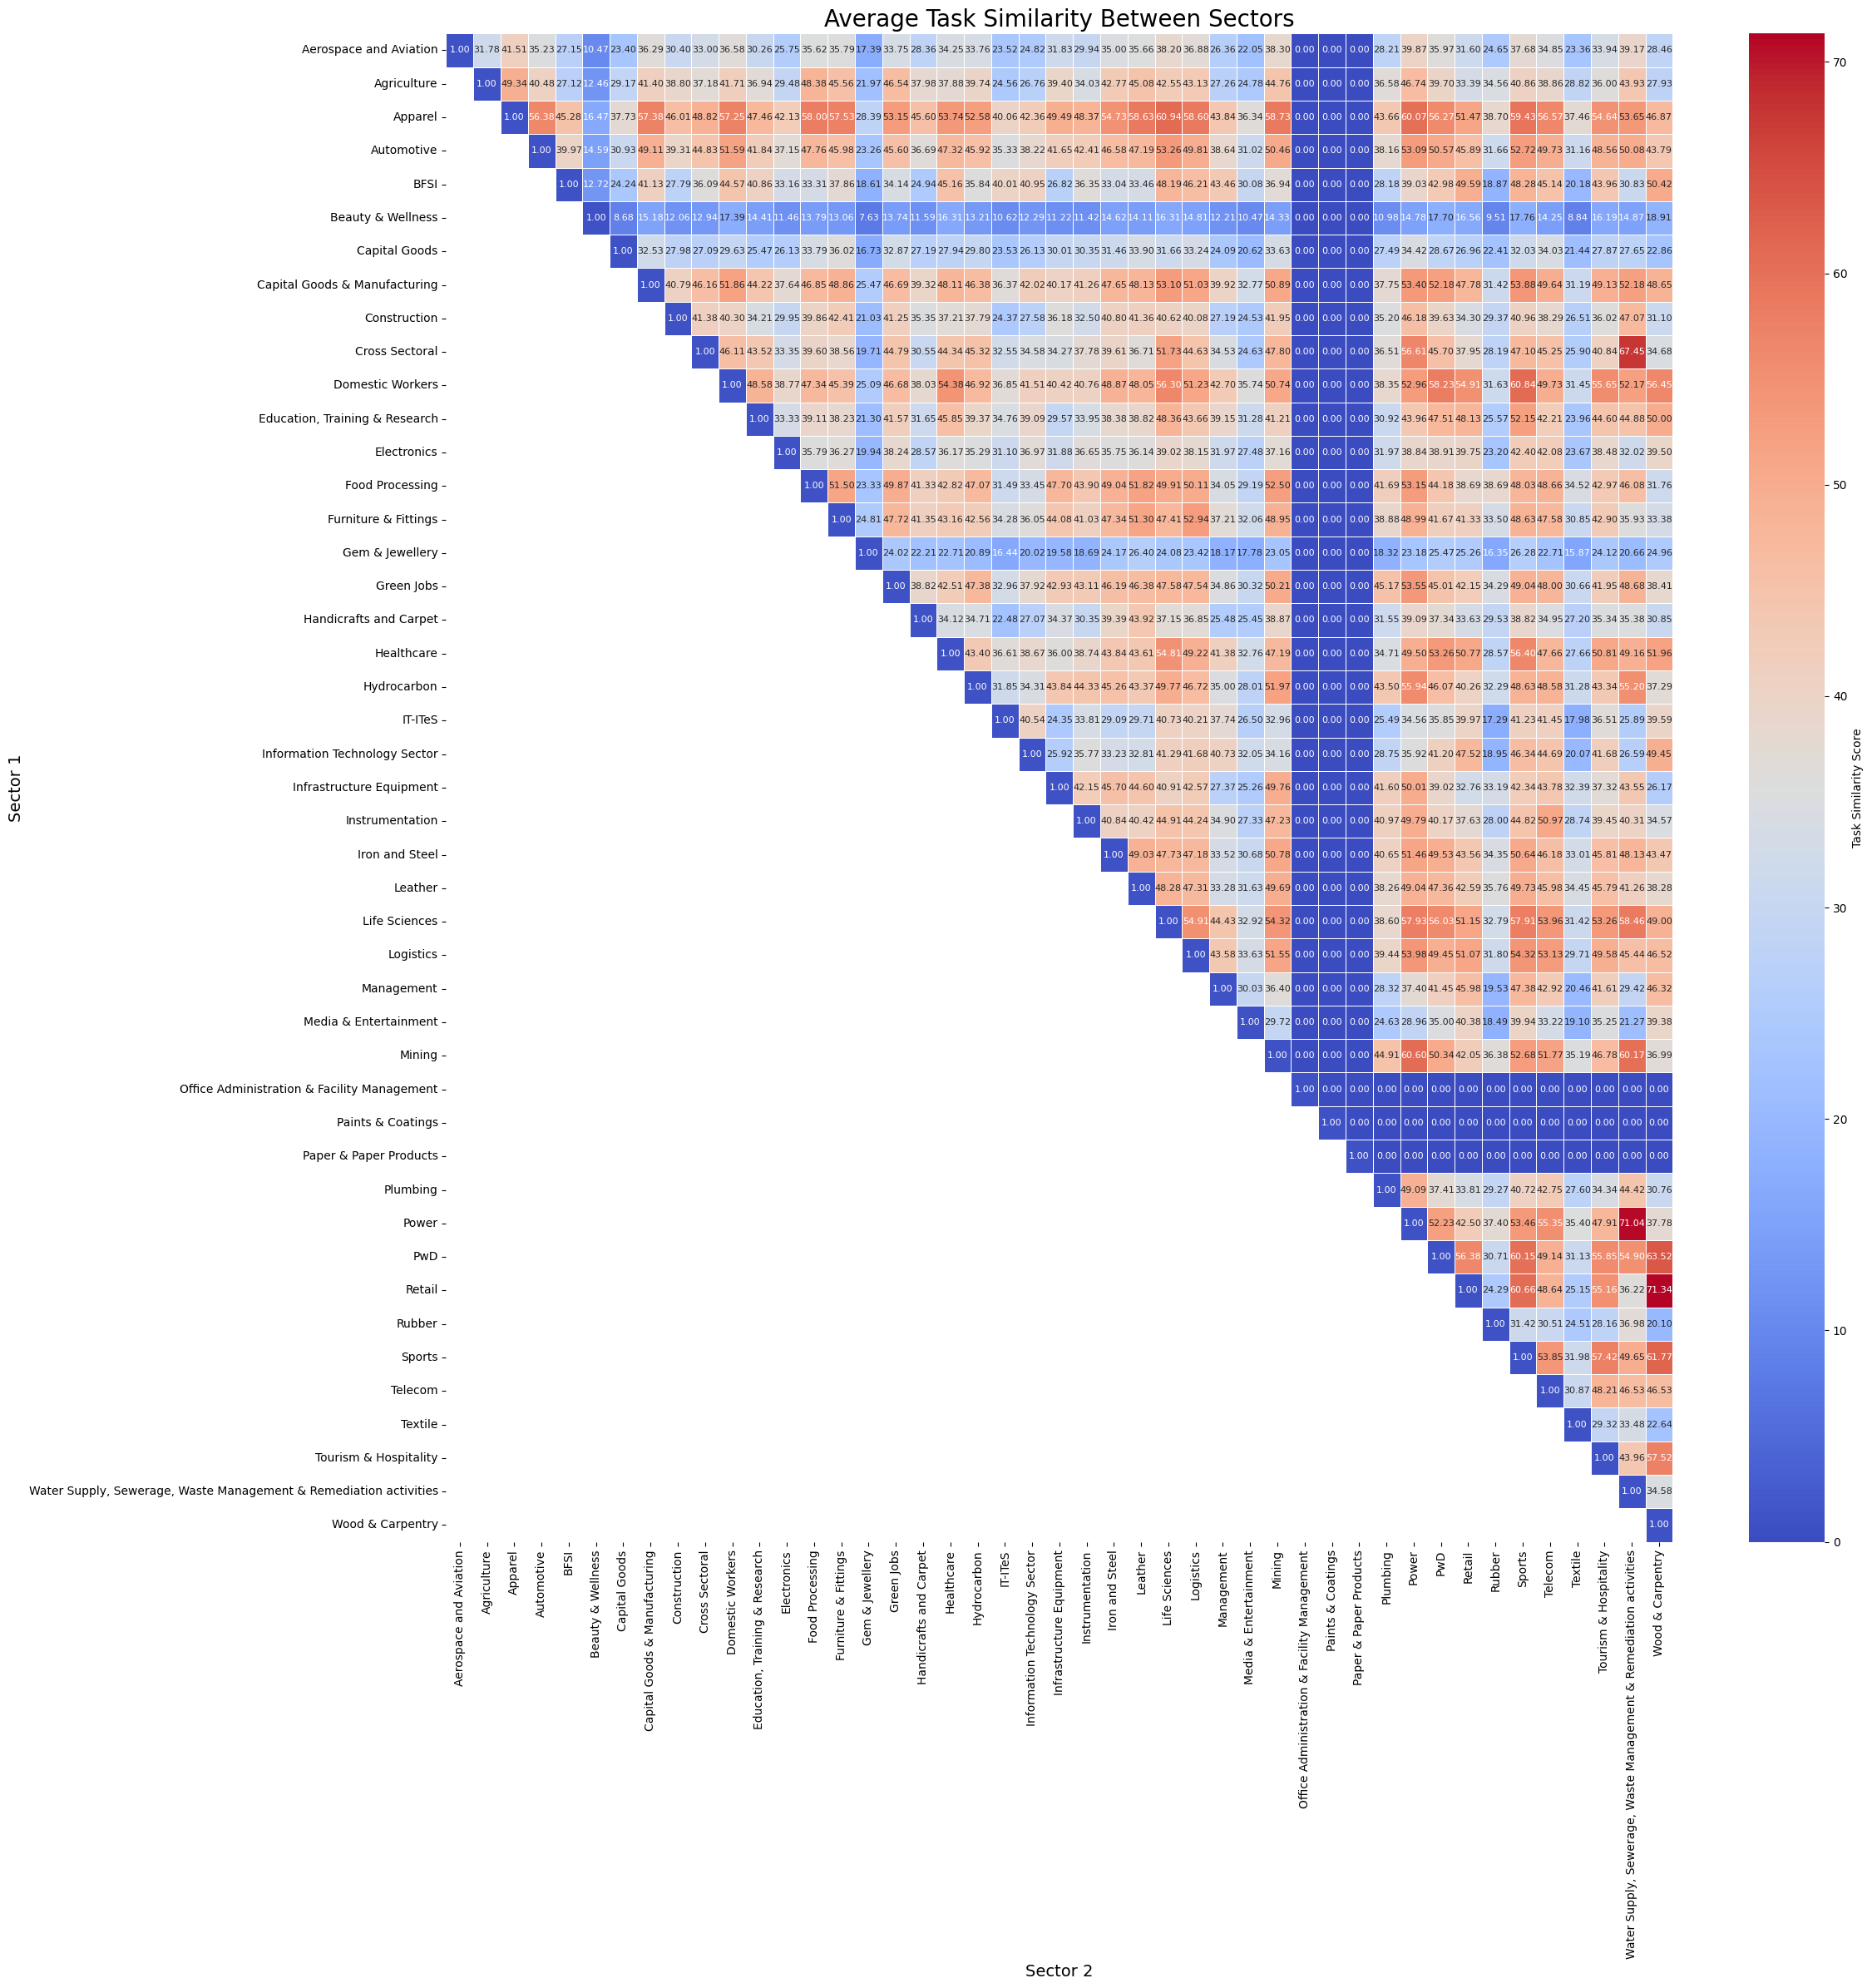

Heatmap generated: sector_task_similarity_heatmap.png
Consolidated table generated: sector_task_similarity_table.csv


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Set a large display limit for Pandas DataFrames for diagnostics
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- CONFIGURATION ---
PARQUET_FILE = 'all_similarities.paraquet'
CSV_FILE = 'qp-listings.csv'
# Updated output names to reflect the specific "Task" similarity focus
OUTPUT_HEATMAP = 'sector_task_similarity_heatmap.png'
OUTPUT_TABLE = 'sector_task_similarity_table.csv'

# --- DATA LOADING AND CLEANING ---

# 1. Load the datasets, handling potential filename variations
try:
    df_sim = pd.read_parquet(PARQUET_FILE)
except FileNotFoundError:
    df_sim = pd.read_parquet('all_similarities.parquet')

df_listings = pd.read_csv(CSV_FILE)

# 2. Standardize a specific sector name to ensure consistent grouping
target_name = "Oï¬ƒce Administration & Facility Management"
new_name = "Administration & Facility Management"
df_listings['Sector Name'] = df_listings['Sector Name'].replace(target_name, new_name)

# 3. Calculate the similarity score
# --- UPDATED CALCULATION LOGIC ---
# As requested, we strictly use the 'task_similarity' column.
# We map it to 'average_similarity' so the rest of the aggregation logic works unchanged.
df_sim['average_similarity'] = df_sim['task_similarity']
# --- END UPDATED CALCULATION LOGIC ---

# --- QP CODE TO SECTOR MAPPING (The Waterfall Logic) ---

# Function to generate the versioned code key (e.g., TSC_Q2301_4.0)
def generate_versioned_key(row):
    """Creates the 'qpCode_version.0' format for advanced matching."""
    code = str(row['qpCode'])
    version = str(row['qp_version'])
    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"

# Create all three potential matching keys in the listing data
df_listings['match_key_1'] = df_listings['qpCode']
df_listings['match_key_2'] = df_listings.apply(generate_versioned_key, axis=1)
df_listings['match_key_3'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)

# Build the comprehensive master mapping dictionary
map_1 = df_listings[['match_key_1', 'Sector Name']].rename(columns={'match_key_1': 'join_key'})
map_2 = df_listings[['match_key_2', 'Sector Name']].rename(columns={'match_key_2': 'join_key'})
map_3 = df_listings[['match_key_3', 'Sector Name']].rename(columns={'match_key_3': 'join_key'})

master_map = pd.concat([map_1, map_2, map_3])
master_map = master_map.dropna(subset=['join_key'])
master_map = master_map[master_map['join_key'] != 'nan']
master_map = master_map.drop_duplicates(subset=['join_key'])

# --- MERGING AND CONSOLIDATION ---

# Merge to get the raw Sector names for both QP codes
df_merged = df_sim.merge(master_map, left_on='qp1_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'RawSector1'}).drop(columns=['join_key'])

df_merged = df_merged.merge(master_map, left_on='qp2_code', right_on='join_key', how='left')
df_merged = df_merged.rename(columns={'Sector Name': 'RawSector2'}).drop(columns=['join_key'])

# Filter out rows where sector mapping failed
df_clean = df_merged.dropna(subset=['RawSector1', 'RawSector2']).copy()

def consolidate_sectors(row):
    """Sorts the two sector names alphabetically to create a canonical pair key.
    This ensures that (A, B) and (B, A) are treated as the same pair for aggregation."""
    s1 = row['RawSector1']
    s2 = row['RawSector2']
    # Use tuple sorting for reliable comparison
    return pd.Series(sorted((s1, s2)), index=['Sector1', 'Sector2'])

# Apply the consolidation logic
df_clean[['Sector1', 'Sector2']] = df_clean.apply(consolidate_sectors, axis=1)

# --- MATRIX CREATION AND SYMMETRIZATION ---

# 1. Calculate the Consolidated Average
# All (A, B) and (B, A) interactions are now averaged together
heatmap_data = df_clean.groupby(['Sector1', 'Sector2'])['average_similarity'].mean().reset_index()

# 2. Pivot the data to a matrix form
heatmap_matrix = heatmap_data.pivot(index='Sector1', columns='Sector2', values='average_similarity')

# 3. Get the complete list of 45 sectors for consistent axis ordering
all_sectors = sorted(df_listings['Sector Name'].dropna().unique())

# 4. Reindex to ensure a 45x45 matrix size, filling missing pairs (which did not interact) with NaN
heatmap_matrix = heatmap_matrix.reindex(index=all_sectors, columns=all_sectors)

# 5. Mirror the data to make the matrix symmetric for display
# This ensures that Similarity(A, B) = Similarity(B, A)
symmetric_matrix = heatmap_matrix.fillna(0) + heatmap_matrix.T.fillna(0)

# Final Symmetrization: Fill the lower triangle with the upper triangle values
final_matrix = symmetric_matrix.mask(symmetric_matrix == 0, heatmap_matrix)
final_matrix = final_matrix.fillna(0)

# 6. Apply self-similarity = 1.0 assumption for the diagonal if not provided by data
# Note: If your task_similarity is on a 0-100 scale, you might want to change 1.0 to 100.0 here.
# Keeping it 1.0 to match the "exact same thing" instruction.
np.fill_diagonal(final_matrix.values, np.diag(final_matrix.values) + (1.0 - np.diag(final_matrix.values)))

# --- HEATMAP GENERATION ---

plt.figure(figsize=(24, 24))

# Create mask for the LOWER triangle
mask = np.tril(np.ones_like(final_matrix, dtype=bool), k=-1)

sns.heatmap(final_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=.5, cbar_kws={'label': 'Task Similarity Score'},
            annot_kws={"size": 8})

plt.title('Average Task Similarity Between Sectors', fontsize=20)
plt.xlabel('Sector 2', fontsize=14)
plt.ylabel('Sector 1', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

plt.savefig(OUTPUT_HEATMAP)
plt.show()

# --- SAVE TABLE ---

similarity_table = heatmap_data.sort_values(by='average_similarity', ascending=False)
similarity_table.to_csv(OUTPUT_TABLE, index=False)

print(f"Heatmap generated: {OUTPUT_HEATMAP}")
print(f"Consolidated table generated: {OUTPUT_TABLE}")

In [ ]:
import pandas as pd

# --- CONFIGURATION ---
CSV_FILE = '/content/qp_listings_current_jobs - Sheet1.csv'
OUTPUT_COUNTS_FILE = 'sector_job_counts.csv'

# --- DATA LOADING ---
try:
    df_listings = pd.read_csv(CSV_FILE)
    print(f"Successfully loaded {len(df_listings)} listings from {CSV_FILE}")
except FileNotFoundError:
    print(f"Error: The file '{CSV_FILE}' was not found.")
    exit()

# --- DATA CLEANING ---
# Standardize the sector name to ensure counts aren't split between two versions of the same sector
target_name = "Oï¬ƒce Administration & Facility Management"
new_name = "Administration & Facility Management"
df_listings['Sector Name'] = df_listings['Sector Name'].replace(target_name, new_name)

# --- COUNT JOBS PER SECTOR ---
# value_counts() counts unique values in the 'Sector Name' column
# reset_index() converts the resulting Series back into a DataFrame
sector_counts = df_listings['Sector Name'].value_counts().reset_index()

# Rename the columns for clarity in the final CSV
sector_counts.columns = ['Sector Name', 'Job Count']

# --- SAVE TO CSV ---
sector_counts.to_csv(OUTPUT_COUNTS_FILE, index=False)

print(f"\nJob counts by sector have been saved to: {OUTPUT_COUNTS_FILE}")

# Optional: Display the top 5 sectors in the console
print("\nTop 5 Sectors by Job Count:")
print(sector_counts.head())

Successfully loaded 2274 listings from /content/qp_listings_current_jobs - Sheet1.csv

Job counts by sector have been saved to: sector_job_counts.csv

Top 5 Sectors by Job Count:
             Sector Name  Job Count
0             Automotive        210
1            Agriculture        180
2  Media & Entertainment        148
3            Electronics        124
4                IT-ITeS        117


In [ ]:
import pandas as pd
import numpy as np
import os

# --- CONFIGURATION ---
PARQUET_FILE = 'all_similarities.paraquet'
CSV_FILE = '/content/qp_listings_current_jobs - Sheet1.csv'

def check_matching_stats():
    print("--- Loading Data ---")

    # 1. Load Listings
    if not os.path.exists(CSV_FILE):
        print(f"Error: {CSV_FILE} not found.")
        return
    df_listings = pd.read_csv(CSV_FILE)
    print(f"Loaded {len(df_listings)} listings from {CSV_FILE}")

    # 2. Load Similarity Data (to get the valid codes)
    # Handle the .paraquet vs .parquet typo check
    if os.path.exists(PARQUET_FILE):
        sim_file = PARQUET_FILE
    elif os.path.exists('all_similarities.parquet'):
        sim_file = 'all_similarities.parquet'
    else:
        print("Error: Parquet file not found.")
        return

    try:
        df_sim = pd.read_parquet(sim_file)
        print(f"Loaded similarity data from {sim_file}")
    except Exception as e:
        print(f"Error reading parquet file: {e}")
        return

    # --- PREPARE MATCHING SET ---
    # We need the set of all unique QP codes that exist in the similarity file.
    # We look at both qp1_code and qp2_code columns.
    # We convert to string to ensure consistent matching against the listings.
    sim_codes = set(df_sim['qp1_code'].astype(str).unique()).union(set(df_sim['qp2_code'].astype(str).unique()))
    print(f"Found {len(sim_codes)} unique QP codes in the similarity file.")

    # --- GENERATE KEYS IN LISTINGS ---

    # 1. Key 1: Raw QP Code
    df_listings['match_key_1'] = df_listings['qpCode'].astype(str)

    # 2. Key 2: Versioned Key
    def generate_versioned_key(row):
        code = str(row['qpCode'])
        version = str(row['qp_version'])
        if '.' not in version:
            version = version + ".0"
        return f"{code}_{version}"

    df_listings['match_key_2'] = df_listings.apply(generate_versioned_key, axis=1).astype(str)

    # 3. Key 3: Filename Key
    # We handle NaN filenames by converting them to 'nan', which won't match valid codes
    df_listings['match_key_3'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)

    # --- CALCULATE MATCHES ---

    print("\n--- Matching Statistics ---")

    # Check overlaps
    # isin(sim_codes) returns a boolean Series (True if the key exists in the sim file)
    match_1 = df_listings['match_key_1'].isin(sim_codes)
    match_2 = df_listings['match_key_2'].isin(sim_codes)
    match_3 = df_listings['match_key_3'].isin(sim_codes)

    # Counts
    count_1 = match_1.sum()
    count_2 = match_2.sum()
    count_3 = match_3.sum()

    # Total Union (Rows matched by AT LEAST ONE of the keys)
    # The | operator acts as a logical OR
    any_match = match_1 | match_2 | match_3
    total_unique_matches = any_match.sum()

    print(f"1. Matches via QP Code (Key 1):      {count_1}")
    print(f"2. Matches via Versioned Key (Key 2): {count_2}")
    print(f"3. Matches via Filename (Key 3):      {count_3}")
    print("-" * 40)
    print(f"Total jobs matched (by at least one key): {total_unique_matches}")
    print(f"Total jobs NOT matched:                   {len(df_listings) - total_unique_matches}")

if __name__ == "__main__":
    check_matching_stats()

--- Loading Data ---
Loaded 2274 listings from /content/qp_listings_current_jobs - Sheet1.csv
Loaded similarity data from all_similarities.parquet
Found 2274 unique QP codes in the similarity file.

--- Matching Statistics ---
1. Matches via QP Code (Key 1):      617
2. Matches via Versioned Key (Key 2): 0
3. Matches via Filename (Key 3):      2141
----------------------------------------
Total jobs matched (by at least one key): 2254
Total jobs NOT matched:                   20


In [ ]:
import pandas as pd
import os

# --- CONFIGURATION ---
PARQUET_FILE = 'all_similarities.paraquet'
CSV_FILE = '/content/qp_listings_current_jobs - Sheet1.csv'
OUTPUT_UNMATCHED = 'unmatched_jobs_list.csv'

# --- DATA LOADING ---
# 1. Load Listings
if not os.path.exists(CSV_FILE):
    # Fallback to the specific filename mentioned in your logs if the variable differs
    CSV_FILE = '/content/qp_listings_current_jobs - Sheet1.csv'

try:
    df_listings = pd.read_csv(CSV_FILE)
    print(f"Loaded listings: {len(df_listings)}")
except FileNotFoundError:
    print(f"Error: Could not find CSV file at {CSV_FILE}")
    exit()

# 2. Load Similarity Data
if os.path.exists(PARQUET_FILE):
    sim_path = PARQUET_FILE
elif os.path.exists('all_similarities.parquet'):
    sim_path = 'all_similarities.parquet'
else:
    print("Error: Parquet file not found.")
    exit()

df_sim = pd.read_parquet(sim_path)

# --- TASK 1: COUNT UNIQUE QP CODES IN PARQUET ---
# We combine qp1_code and qp2_code to ensure we capture every unique code present
unique_sim_codes = set(df_sim['qp1_code'].astype(str).unique()).union(set(df_sim['qp2_code'].astype(str).unique()))
print(f"Number of unique QP codes in Parquet file: {len(unique_sim_codes)}")

# --- TASK 2: IDENTIFY UNMATCHED JOBS ---

# Re-create the matching keys
# Key 1: Raw QP Code
df_listings['match_key_1'] = df_listings['qpCode'].astype(str)

# Key 2: Versioned Key
def generate_versioned_key(row):
    code = str(row['qpCode'])
    version = str(row['qp_version'])
    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"

df_listings['match_key_2'] = df_listings.apply(generate_versioned_key, axis=1).astype(str)

# Key 3: Filename Key
df_listings['match_key_3'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)

# Check matches against the set of codes from the parquet file
match_1 = df_listings['match_key_1'].isin(unique_sim_codes)
match_2 = df_listings['match_key_2'].isin(unique_sim_codes)
match_3 = df_listings['match_key_3'].isin(unique_sim_codes)

# Identify rows that have NO match in any of the 3 keys
df_listings['is_matched'] = match_1 | match_2 | match_3
unmatched_jobs = df_listings[~df_listings['is_matched']].copy()

# --- SAVE OUTPUT ---
print(f"Found {len(unmatched_jobs)} unmatched jobs.")

if not unmatched_jobs.empty:
    # Select relevant columns to inspect (adjust columns as needed based on your CSV structure)
    cols_to_save = ['qpCode', 'qp_version', 'matched_filename', 'Sector Name', 'Job Title']
    # Use intersection to only save columns that actually exist in your dataframe
    valid_cols = [c for c in cols_to_save if c in unmatched_jobs.columns]

    unmatched_jobs[valid_cols].to_csv(OUTPUT_UNMATCHED, index=False)
    print(f"List of unmatched jobs saved to: {OUTPUT_UNMATCHED}")
else:
    print("All jobs were matched successfully!")

Loaded listings: 2274
Number of unique QP codes in Parquet file: 2274
Found 20 unmatched jobs.
List of unmatched jobs saved to: unmatched_jobs_list.csv


In [ ]:
import pandas as pd
import os

# --- CONFIGURATION ---
PARQUET_FILE = 'all_similarities.paraquet'
CSV_FILE = 'qp-listings.csv'
OUTPUT_FILE = 'unmatched_parquet_codes.csv'

# --- DATA LOADING ---

# 1. Load Similarity Data (The Parquet File)
if os.path.exists(PARQUET_FILE):
    sim_path = PARQUET_FILE
elif os.path.exists('all_similarities.parquet'):
    sim_path = 'all_similarities.parquet'
else:
    print("Error: Parquet file not found.")
    exit()

df_sim = pd.read_parquet(sim_path)

# 2. Load Listings Data (The CSV File)
# Fallback to the specific filename if 'qp-listings.csv' isn't found
if not os.path.exists(CSV_FILE):
    CSV_FILE = '/content/qp_listings_current_jobs - Sheet1.csv'

try:
    df_listings = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"Error: Could not find CSV file at {CSV_FILE}")
    exit()

# --- STEP 1: GET ALL CODES PRESENT IN PARQUET ---
# We combine qp1_code and qp2_code columns to get the master list of available codes
parquet_codes = set(df_sim['qp1_code'].astype(str).unique()).union(set(df_sim['qp2_code'].astype(str).unique()))
print(f"Total unique codes in Parquet file: {len(parquet_codes)}")

# --- STEP 2: GENERATE ALL KEYS FROM LISTINGS ---
# We recreate the 3 keys used in the matching process

# Key 1: Raw QP Code
key1_set = set(df_listings['qpCode'].astype(str).unique())

# Key 2: Versioned Key
def generate_versioned_key(row):
    code = str(row['qpCode'])
    version = str(row['qp_version'])
    if '.' not in version:
        version = version + ".0"
    return f"{code}_{version}"

key2_set = set(df_listings.apply(generate_versioned_key, axis=1).astype(str).unique())

# Key 3: Filename Key
# Handle potential NaNs in filename just in case
if 'matched_filename' in df_listings.columns:
    key3_set = set(df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False).unique())
else:
    key3_set = set()

# Combine all listing keys into one "Attempted Keys" set
all_listing_keys = key1_set.union(key2_set).union(key3_set)

# --- STEP 3: FIND THE DIFFERENCE ---
# Find codes that exist in Parquet but were NOT found in the Listings keys
# Logic: (Parquet Codes) MINUS (Listing Keys)
unmatched_codes = parquet_codes - all_listing_keys

# --- STEP 4: SAVE THE OUTPUT ---
print(f"Number of Parquet codes not matched by any listing: {len(unmatched_codes)}")

if unmatched_codes:
    # Create a DataFrame and save
    df_unmatched = pd.DataFrame(list(unmatched_codes), columns=['unmatched_qp_code'])
    df_unmatched.to_csv(OUTPUT_FILE, index=False)
    print(f"List of unmatched Parquet codes saved to: {OUTPUT_FILE}")
else:
    print("All codes in the Parquet file were successfully matched by at least one listing.")

Total unique codes in Parquet file: 2274
Number of Parquet codes not matched by any listing: 20
List of unmatched Parquet codes saved to: unmatched_parquet_codes.csv


In [ ]:
import pandas as pd
import io
import os

# --- CONFIGURATION ---
PARQUET_FILE = 'all_similarities.paraquet'
CSV_FILE = 'qp-listings.csv'
OUTPUT_FILE = 'all_similarities_enriched.parquet'

# --- 1. LOAD DATA ---

# Load Listings
try:
    df_listings = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    # Fallback for your specific environment path if needed
    df_listings = pd.read_csv('/content/qp_listings_current_jobs - Sheet1.csv')

# Load Parquet
if os.path.exists(PARQUET_FILE):
    df_sim = pd.read_parquet(PARQUET_FILE)
else:
    df_sim = pd.read_parquet('all_similarities.parquet')

# Load Manual Mappings (from your prompt)
manual_mapping_data = """qpCode,qp_code_from_paraquet_file
AGR/Q0701,AGR_Q0701_3.0
ASC/Q1444,ASC_Q1444_1.0
ASC/Q6421,ASC_Q6421_1.0
ASC/Q6424,ASC_Q6424_1.0
BWS/Q0101,BWS_Q0101_4.0
BWS/Q0202,BWS_Q0202_4.0
BWS/Q2203,BWS_Q2203_3.0
BWS/Q2205,BWS_Q2205_3.0
BWS/Q3003,BWS_Q3003_3.0
CUTM/AGR/Q0202,CUTM_AGR_Q0202_1.0
CUTM/AGR/Q0401,CUTM_AGR_Q0401_1.0
CUTM/CSC/Q0203,CUTM_CSC_Q0203_1.0
CUTM/ELE/Q0101,CUTM_ELE_Q0101_1.0
IAS/Q8007,IAS_Q8007_1.0
ICE/CON/Q0201,ICE_CON_Q0201_1.0
MIN/Q3203,MIN_Q3203_2.0
NFD/MES/Q0301,NFD_MES_Q0301_2.0
NFD/MES/Q0901,NFD_MES_Q0901_1.0
RAS/Q0109,RAS_Q0109_2.0
TSC/Q0302,TSC_Q0302_4.0"""

df_manual = pd.read_csv(io.StringIO(manual_mapping_data))

# --- 2. PREPARE METADATA LOOKUP DICTIONARY ---

# We need a dictionary where:
# Key = The Code string found in the Parquet file (e.g., 'AGR_Q0701_3.0' or 'TSC_Q2301_4.0')
# Value = A dictionary of the Metadata from the CSV (Sector, Role, etc.)

# Helper to normalize keys
df_listings['key_filename'] = df_listings['matched_filename'].astype(str).str.replace('.json', '', regex=False)
df_listings['key_qpcode'] = df_listings['qpCode'].astype(str)

# Create a dictionary to hold the clean metadata for every known Parquet code
# Format: { 'Parquet_Code_String': { 'Sector Name': ..., 'qp_code': ..., ... } }
master_lookup = {}

# A. POPULATE VIA AUTOMATIC MATCHING (Filename is most reliable)
# We iterate through listings and map the filename key to the row data
for _, row in df_listings.iterrows():
    metadata = {
        'matched_filename': row['matched_filename'],
        'nsqfLevel': row['nsqfLevel'],
        'qp_code': row['qpCode'], # This is the clean code from CSV
        'Sector Name': row['Sector Name'],
        'jobRole': row['jobRole'] # Renaming Job Title to jobRole
    }

    # Map the Filename key (matches 2141 jobs)
    master_lookup[row['key_filename']] = metadata

    # Map the QP Code key (matches 617 jobs)
    # Note: Filename matches usually overwrite this if they are more specific,
    # but since they point to the same row, it's fine.
    master_lookup[row['key_qpcode']] = metadata

# B. POPULATE VIA MANUAL MAPPING (The 20 rows)
# These overwrite any previous partial matches because they are explicit
for _, row in df_manual.iterrows():
    csv_code = row['qpCode']
    parquet_code = row['qp_code_from_paraquet_file']

    # Find the metadata in the listings using the CSV code
    listing_row = df_listings[df_listings['qpCode'] == csv_code]

    if not listing_row.empty:
        r = listing_row.iloc[0]
        metadata = {
            'matched_filename': r['matched_filename'],
            'nsqfLevel': r['nsqfLevel'],
            'qp_code': r['qpCode'],
            'Sector Name': r['Sector Name'],
            'jobRole': r['jobRole']
        }
        # Map the PARQUET code to this metadata
        master_lookup[parquet_code] = metadata

# --- 3. APPLY MAPPING TO PARQUET DATAFRAME ---

print("Mapping metadata to QP1 columns...")
# Convert the lookup dictionary to a DataFrame for efficient merging
df_lookup = pd.DataFrame.from_dict(master_lookup, orient='index')

# Merge for QP1
# We perform a Left Join on qp1_code against the lookup index
df_merged = df_sim.merge(df_lookup, left_on='qp1_code', right_index=True, how='left')

# Rename the columns to have _1 suffix
rename_map_1 = {
    'matched_filename': 'matched_filename_1',
    'nsqfLevel': 'nsqfLevel_1',
    'qp_code': 'qp_code_1',
    'Sector Name': 'Sector Name_1',
    'jobRole': 'jobRole_1'
}
df_merged = df_merged.rename(columns=rename_map_1)

print("Mapping metadata to QP2 columns...")
# Merge for QP2
df_merged = df_merged.merge(df_lookup, left_on='qp2_code', right_index=True, how='left')

# Rename the columns to have _2 suffix
rename_map_2 = {
    'matched_filename': 'matched_filename_2',
    'nsqfLevel': 'nsqfLevel_2',
    'qp_code': 'qp_code_2',
    'Sector Name': 'Sector Name_2',
    'jobRole': 'jobRole_2'
}
df_merged = df_merged.rename(columns=rename_map_2)

# --- 4. REORDER AND SAVE ---

# Define the exact column order desired
# Existing similarity columns + New Metadata columns
final_columns = [
    'qp1_code', 'qp2_code',
    'embedding_similarity', 'task_similarity', 'nsqf_level_similarity',
    'qp_code_1', 'matched_filename_1', 'nsqfLevel_1', 'Sector Name_1', 'jobRole_1',
    'qp_code_2', 'matched_filename_2', 'nsqfLevel_2', 'Sector Name_2', 'jobRole_2'
]

# Ensure we only select columns that exist (in case some didn't generate)
available_cols = [c for c in final_columns if c in df_merged.columns]
df_final = df_merged[available_cols]

# Save
df_final.to_parquet(OUTPUT_FILE)

print(f"Success! Enriched Parquet file saved to: {OUTPUT_FILE}")
print(f"Original Rows: {len(df_sim)}")
print(f"Final Rows: {len(df_final)}")
print("\nSample of new columns (QP1 side):")
print(df_final[['qp1_code', 'qp_code_1', 'Sector Name_1']].head())

Mapping metadata to QP1 columns...
Mapping metadata to QP2 columns...
Success! Enriched Parquet file saved to: all_similarities_enriched.parquet
Original Rows: 2584401
Final Rows: 2584401

Sample of new columns (QP1 side):
        qp1_code  qp_code_1    Sector Name_1
0  IAS_Q3001_8.0  IAS/Q3001  Instrumentation
1  IAS_Q3001_8.0  IAS/Q3001  Instrumentation
2  IAS_Q3001_8.0  IAS/Q3001  Instrumentation
3  IAS_Q3001_8.0  IAS/Q3001  Instrumentation
4  IAS_Q3001_8.0  IAS/Q3001  Instrumentation


In [ ]:
import pandas as pd
import os

# --- CONFIGURATION ---
INPUT_FILE = 'all_similarities_enriched.parquet'
OUTPUT_FILE = 'all_similarities_final.parquet'

# --- EXECUTION ---
if not os.path.exists(INPUT_FILE):
    print(f"Error: The file '{INPUT_FILE}' was not found. Please run the previous enrichment script first.")
else:
    # 1. Load the enriched file
    df = pd.read_parquet(INPUT_FILE)

    # 2. Drop the requested columns
    cols_to_drop = ['qp1_code', 'qp2_code']
    df_clean = df.drop(columns=cols_to_drop, errors='ignore')

    # 3. Save the final file
    df_clean.to_parquet(OUTPUT_FILE)

    print(f"Columns {cols_to_drop} have been removed.")
    print(f"Final clean file saved to: {OUTPUT_FILE}")
    print("\nRemaining columns:")
    print(df_clean.columns.tolist())

Columns ['qp1_code', 'qp2_code'] have been removed.
Final clean file saved to: all_similarities_final.parquet

Remaining columns:
['embedding_similarity', 'task_similarity', 'nsqf_level_similarity', 'qp_code_1', 'matched_filename_1', 'nsqfLevel_1', 'Sector Name_1', 'jobRole_1', 'qp_code_2', 'matched_filename_2', 'nsqfLevel_2', 'Sector Name_2', 'jobRole_2']


Loaded 2584401 rows from similarity file.


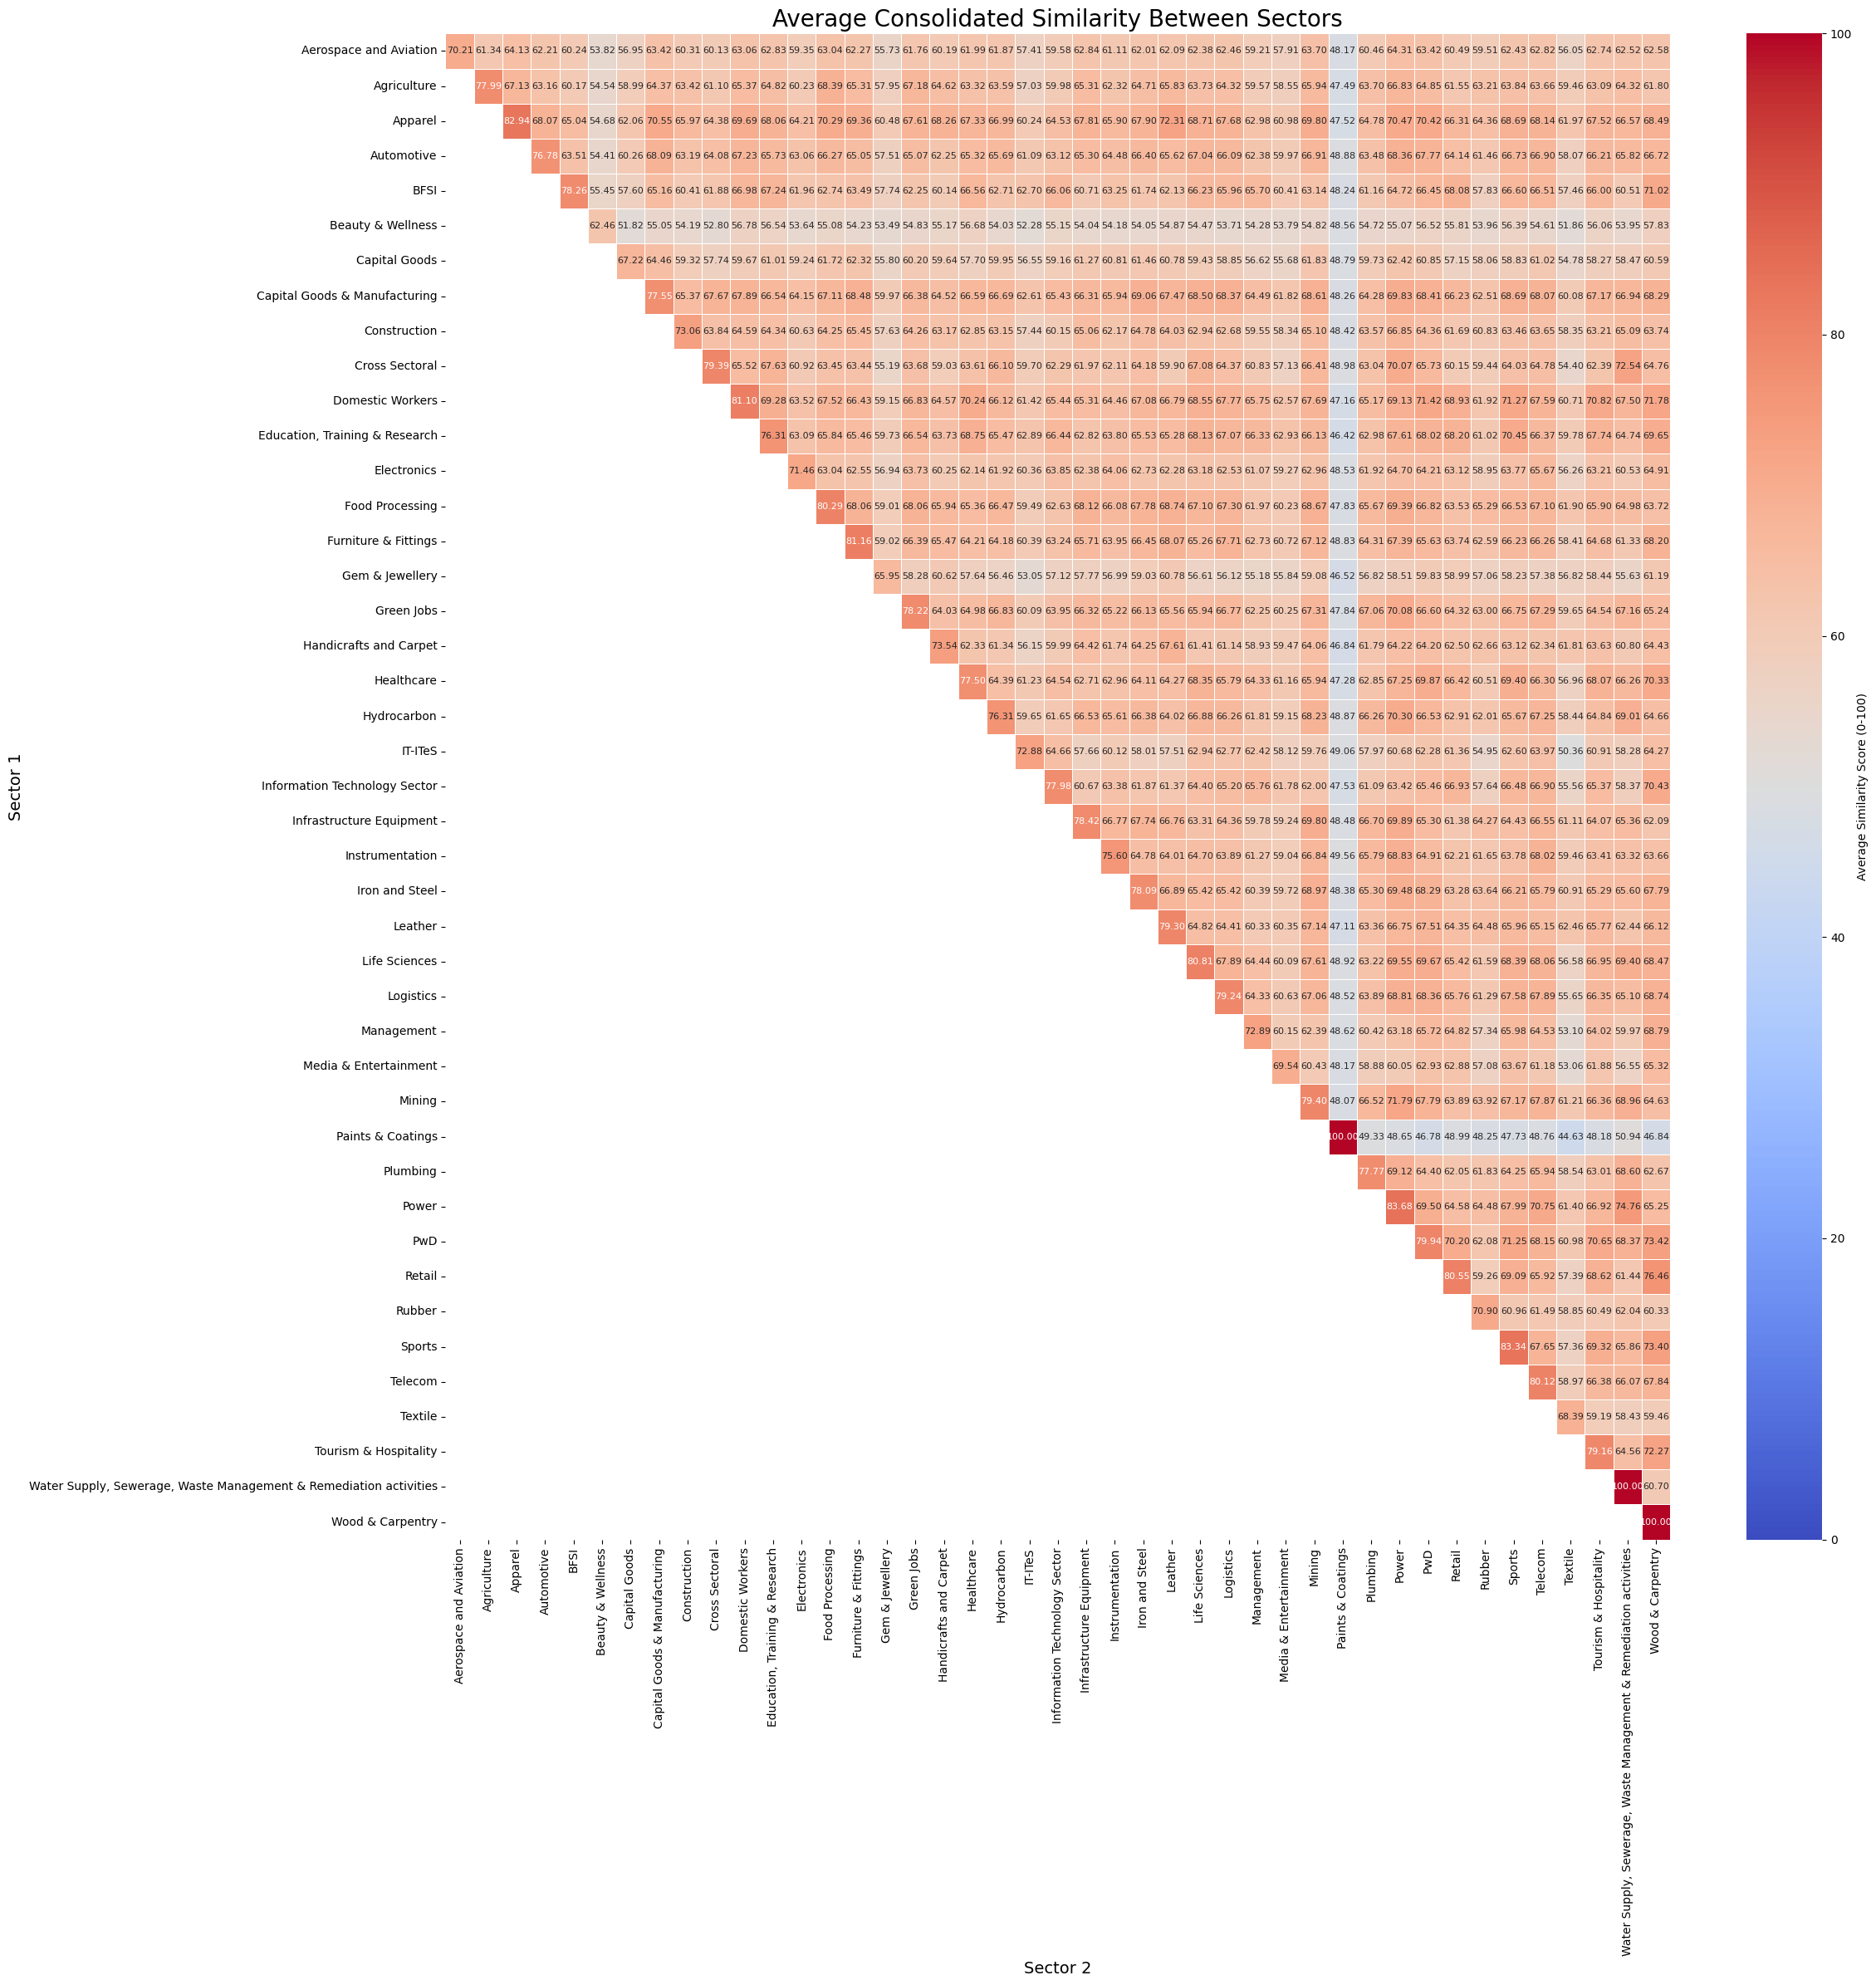

Heatmap generated: sector_similarity_heatmap_final.png
Consolidated table generated: sector_similarity_table_final.csv
Table contains 1849 rows (should be approx 1849).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# --- CONFIGURATION ---
PARQUET_FILE = 'all_similarities_final.parquet'
CSV_FILE = 'qp-listings.csv'
OUTPUT_HEATMAP = 'sector_similarity_heatmap_final.png'
OUTPUT_TABLE = 'sector_similarity_table_final.csv'

# --- DATA LOADING ---

if not os.path.exists(PARQUET_FILE):
    print(f"Error: {PARQUET_FILE} not found.")
    exit()

df_sim = pd.read_parquet(PARQUET_FILE)
print(f"Loaded {len(df_sim)} rows from similarity file.")

# Load Listings (Used for the master sector list)
try:
    df_listings = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    df_listings = pd.read_csv('/content/qp_listings_current_jobs.csv')

# --- DATA CLEANING & STANDARDIZATION ---

target_name = "Oï¬ƒce Administration & Facility Management"
new_name = "Administration & Facility Management"

# 1. Clean Sector Names
df_listings['Sector Name'] = df_listings['Sector Name'].replace(target_name, new_name)

if 'Sector Name_1' in df_sim.columns:
    df_sim['Sector Name_1'] = df_sim['Sector Name_1'].replace(target_name, new_name)
    df_sim['Sector Name_2'] = df_sim['Sector Name_2'].replace(target_name, new_name)

df_clean = df_sim.dropna(subset=['Sector Name_1', 'Sector Name_2']).copy()

# --- CALCULATE SCORES ---

scaled_embedding = df_clean['embedding_similarity'] * 100
df_clean['average_similarity'] = (scaled_embedding + df_clean['task_similarity'] + df_clean['nsqf_level_similarity']) / 3

# --- CONSOLIDATION ---

def consolidate_sectors(row):
    """Sorts sector names to ensure (A, B) and (B, A) are treated as the same pair."""
    s1 = row['Sector Name_1']
    s2 = row['Sector Name_2']
    return pd.Series(sorted((s1, s2)), index=['Sector1', 'Sector2'])

df_clean[['Sector1', 'Sector2']] = df_clean.apply(consolidate_sectors, axis=1)

# --- MATRIX CREATION ---

# 1. Group and Average (Consolidated Data)
grouped_data = df_clean.groupby(['Sector1', 'Sector2'])['average_similarity'].mean().reset_index()

# 2. Pivot to Matrix
heatmap_matrix = grouped_data.pivot(index='Sector1', columns='Sector2', values='average_similarity')

# 3. Reindex to ensure ALL sectors are present (creates rows/cols of NaNs for missing sectors)
all_sectors = sorted(df_listings['Sector Name'].dropna().unique())
heatmap_matrix = heatmap_matrix.reindex(index=all_sectors, columns=all_sectors)

# 4. Symmetrize the Matrix
# This fills NaNs with 0 and adds the transpose to fill the lower triangle
symmetric_matrix = heatmap_matrix.fillna(0) + heatmap_matrix.T.fillna(0)

# 5. Fix Doubling (Divide by 2)
# Because the diagonal (A vs A) exists in the matrix, M + M.T doubles it. We fix that.
diag = np.diag(symmetric_matrix)
np.fill_diagonal(symmetric_matrix.values, diag / 2)

# --- 6. IMPUTE MISSING DIAGONALS (0.00 -> 100.00) ---
# This is the specific logic you requested.
# If a sector compared to itself is 0.00 (meaning no data), we set it to 100.00.
# If it has a real calculated value (e.g. 85.0), we leave it alone.

current_diag = np.diag(symmetric_matrix)
new_diag = np.where(current_diag == 0, 100.0, current_diag)
np.fill_diagonal(symmetric_matrix.values, new_diag)

final_matrix = symmetric_matrix

# --- HEATMAP GENERATION ---

plt.figure(figsize=(24, 24))

# Mask the lower triangle for cleaner visualization
mask = np.tril(np.ones_like(final_matrix, dtype=bool), k=-1)

sns.heatmap(final_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=.5, cbar_kws={'label': 'Average Similarity Score (0-100)'},
            annot_kws={"size": 8}, vmin=0, vmax=100)

plt.title('Average Consolidated Similarity Between Sectors', fontsize=20)
plt.xlabel('Sector 2', fontsize=14)
plt.ylabel('Sector 1', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

plt.savefig(OUTPUT_HEATMAP)
plt.show()

# --- SAVE TABLE (FROM MATRIX) ---

# To ensure the CSV matches the heatmap EXACTLY (including the fixed 100s),
# we generate the table from the final_matrix, not the raw data.

# 1. Stack the matrix to create a long list of (Sector 1, Sector 2, Score)
similarity_table = final_matrix.stack().reset_index()
similarity_table.columns = ['Sector 1', 'Sector 2', 'Similarity Score']

# 2. (Optional) Filter out zeros if you want a cleaner file,
# but keep them if you want "all sector comparisons" as requested.`
# We will keep everything to be safe.

# 3. Sort by Score
similarity_table = similarity_table.sort_values(by='Similarity Score', ascending=False)

similarity_table.to_csv(OUTPUT_TABLE, index=False)

print(f"Heatmap generated: {OUTPUT_HEATMAP}")
print(f"Consolidated table generated: {OUTPUT_TABLE}")
print(f"Table contains {len(similarity_table)} rows (should be approx {len(all_sectors)**2}).")

Loaded 2584401 rows from similarity file.
Filtered down to 193753 rows involving the target 8 sectors.


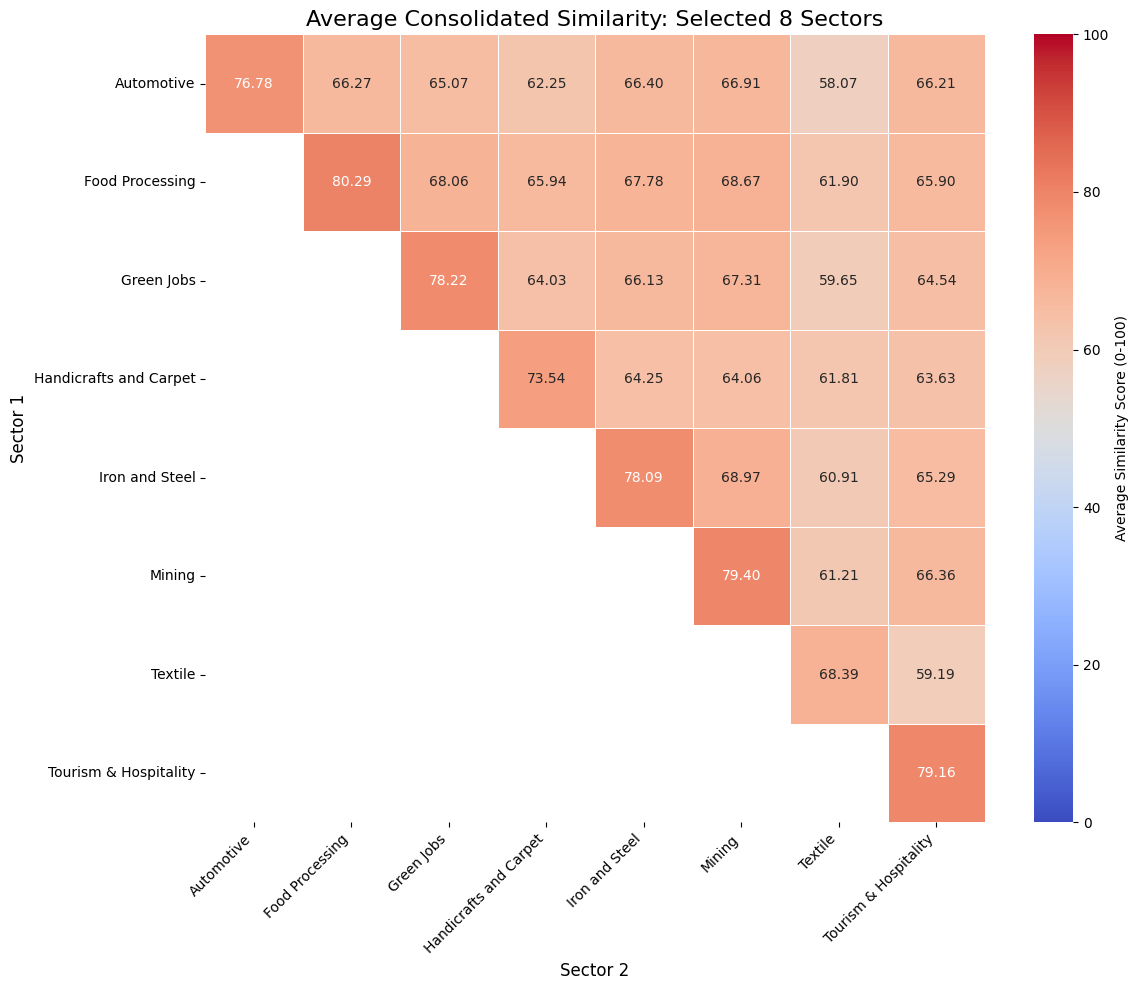

Heatmap generated: sector_similarity_heatmap_8_sectors.png
Consolidated table generated: sector_similarity_table_8_sectors.csv


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# --- CONFIGURATION ---
PARQUET_FILE = 'all_similarities_final.parquet'
CSV_FILE = 'qp-listings.csv'
OUTPUT_HEATMAP = 'sector_similarity_heatmap_8_sectors.png'
OUTPUT_TABLE = 'sector_similarity_table_8_sectors.csv'

# --- 1. DEFINE TARGET SECTORS ---
target_sectors = [
    "Automotive",
    "Food Processing",
    "Green Jobs",
    "Handicrafts and Carpet",
    "Iron and Steel",
    "Mining",
    "Textile",
    "Tourism & Hospitality"
]
# Sort alphabetically for consistent axis ordering
target_sectors = sorted(target_sectors)

# --- 2. DATA LOADING ---

if not os.path.exists(PARQUET_FILE):
    print(f"Error: {PARQUET_FILE} not found. Please ensure the enriched file exists.")
    exit()

df_sim = pd.read_parquet(PARQUET_FILE)
print(f"Loaded {len(df_sim)} rows from similarity file.")

# --- 3. DATA FILTERING & CLEANING ---

# Filter the DataFrame to keep ONLY rows where BOTH sectors are in our target list.
df_subset = df_sim[
    (df_sim['Sector Name_1'].isin(target_sectors)) &
    (df_sim['Sector Name_2'].isin(target_sectors))
].copy()

print(f"Filtered down to {len(df_subset)} rows involving the target 8 sectors.")

if df_subset.empty:
    print("Warning: No data found for the selected sectors. Check exact spelling.")
    exit()

# --- 4. CALCULATE SCORES ---

# Logic: (Embedding * 100 + Task + NSQF) / 3
scaled_embedding = df_subset['embedding_similarity'] * 100
df_subset['average_similarity'] = (scaled_embedding + df_subset['task_similarity'] + df_subset['nsqf_level_similarity']) / 3

# --- 5. CONSOLIDATION LOGIC ---

def consolidate_sectors(row):
    """Sorts the two sector names alphabetically to create a canonical pair.
    This ensures (Automotive, Mining) and (Mining, Automotive) are aggregated together."""
    s1 = row['Sector Name_1']
    s2 = row['Sector Name_2']
    return pd.Series(sorted((s1, s2)), index=['Sector1', 'Sector2'])

# Apply sorting
df_subset[['Sector1', 'Sector2']] = df_subset.apply(consolidate_sectors, axis=1)

# --- 6. MATRIX CREATION ---

# 1. Group and Average
heatmap_data = df_subset.groupby(['Sector1', 'Sector2'])['average_similarity'].mean().reset_index()

# 2. Pivot to Matrix
heatmap_matrix = heatmap_data.pivot(index='Sector1', columns='Sector2', values='average_similarity')

# 3. Reindex to ensure strictly 8x8 size
heatmap_matrix = heatmap_matrix.reindex(index=target_sectors, columns=target_sectors)

# 4. Symmetrize the Matrix
# This fills NaNs with 0 and adds the transpose.
symmetric_matrix = heatmap_matrix.fillna(0) + heatmap_matrix.T.fillna(0)

# 5. Fix Doubling (Divide by 2)
# Because the diagonal (A vs A) exists in both matrices, adding them doubles the value.
diag = np.diag(symmetric_matrix)
np.fill_diagonal(symmetric_matrix.values, diag / 2)

# 6. IMPUTE MISSING DIAGONALS (0.00 -> 100.00)
# If a sector compared to itself is 0.00 (meaning no data), set to 100.00.
current_diag = np.diag(symmetric_matrix)
new_diag = np.where(current_diag == 0, 100.0, current_diag)
np.fill_diagonal(symmetric_matrix.values, new_diag)

final_matrix = symmetric_matrix

# --- 7. HEATMAP GENERATION ---

plt.figure(figsize=(12, 10))

# Create mask for the LOWER triangle (Top-Right visible)
mask = np.tril(np.ones_like(final_matrix, dtype=bool), k=-1)

sns.heatmap(final_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=.5, cbar_kws={'label': 'Average Similarity Score (0-100)'},
            annot_kws={"size": 10}, vmin=0, vmax=100)

plt.title('Average Consolidated Similarity: Selected 8 Sectors', fontsize=16)
plt.xlabel('Sector 2', fontsize=12)
plt.ylabel('Sector 1', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

plt.savefig(OUTPUT_HEATMAP)
plt.show()

# --- 8. SAVE TABLE (FROM MATRIX) ---

# Stack matrix to get all pairs (including imputed 100s and 0s)
similarity_table = final_matrix.stack().reset_index()
similarity_table.columns = ['Sector 1', 'Sector 2', 'Similarity Score']

# Sort by Score
similarity_table = similarity_table.sort_values(by='Similarity Score', ascending=False)
similarity_table.to_csv(OUTPUT_TABLE, index=False)

print(f"Heatmap generated: {OUTPUT_HEATMAP}")
print(f"Consolidated table generated: {OUTPUT_TABLE}")